# Modelling and Optimization in _Ticket to Ride_ (Germany and USA)

### __EN__:

The goal of this notebook is to analyze strategies for the game Ticket to Ride, in which players must build railway routes across national maps in order to fulfill objectives defined at the beginning of the game. The strategic challenge lies in achieving these goals while operating under a limited resource budget.

Because the railway network is both large (many cities) and dense (many possible routes), computationally efficient techniques are required. In particular, this work employs exact methods, such as shortest path algorithms, minimum spanning trees, and search techniques, as well as heuristics, with an emphasis on genetic algorithms.

### __PT__:

A proposta deste notebook é analisar estratégias para o jogo Ticket to Ride, no qual os jogadores precisam construir rotas ferroviárias ao longo de mapas nacionais com o objetivo de cumprir metas definidas no início da partida. A dinâmica estratégica consiste em alcançar essas metas respeitando um orçamento limitado de recursos.

Como se trata de uma malha ferroviária extensa (com muitas cidades) e densa (com diversas rotas possíveis), é necessário empregar técnicas computacionalmente eficientes. Em particular, serão utilizados métodos exatos, como algoritmos de caminhos mínimos, árvores geradoras mínimas e técnicas de busca, bem como heurísticas, com destaque para algoritmos genéticos.

# Generating Boards

Using an LLM to estimate the geographical points of towns in real maps, we can plot the boards.

# Germany map

Colunas encontradas no arquivo: Index(['Numero', 'Origem', 'Destino', 'Custo', 'Cor'], dtype='object')


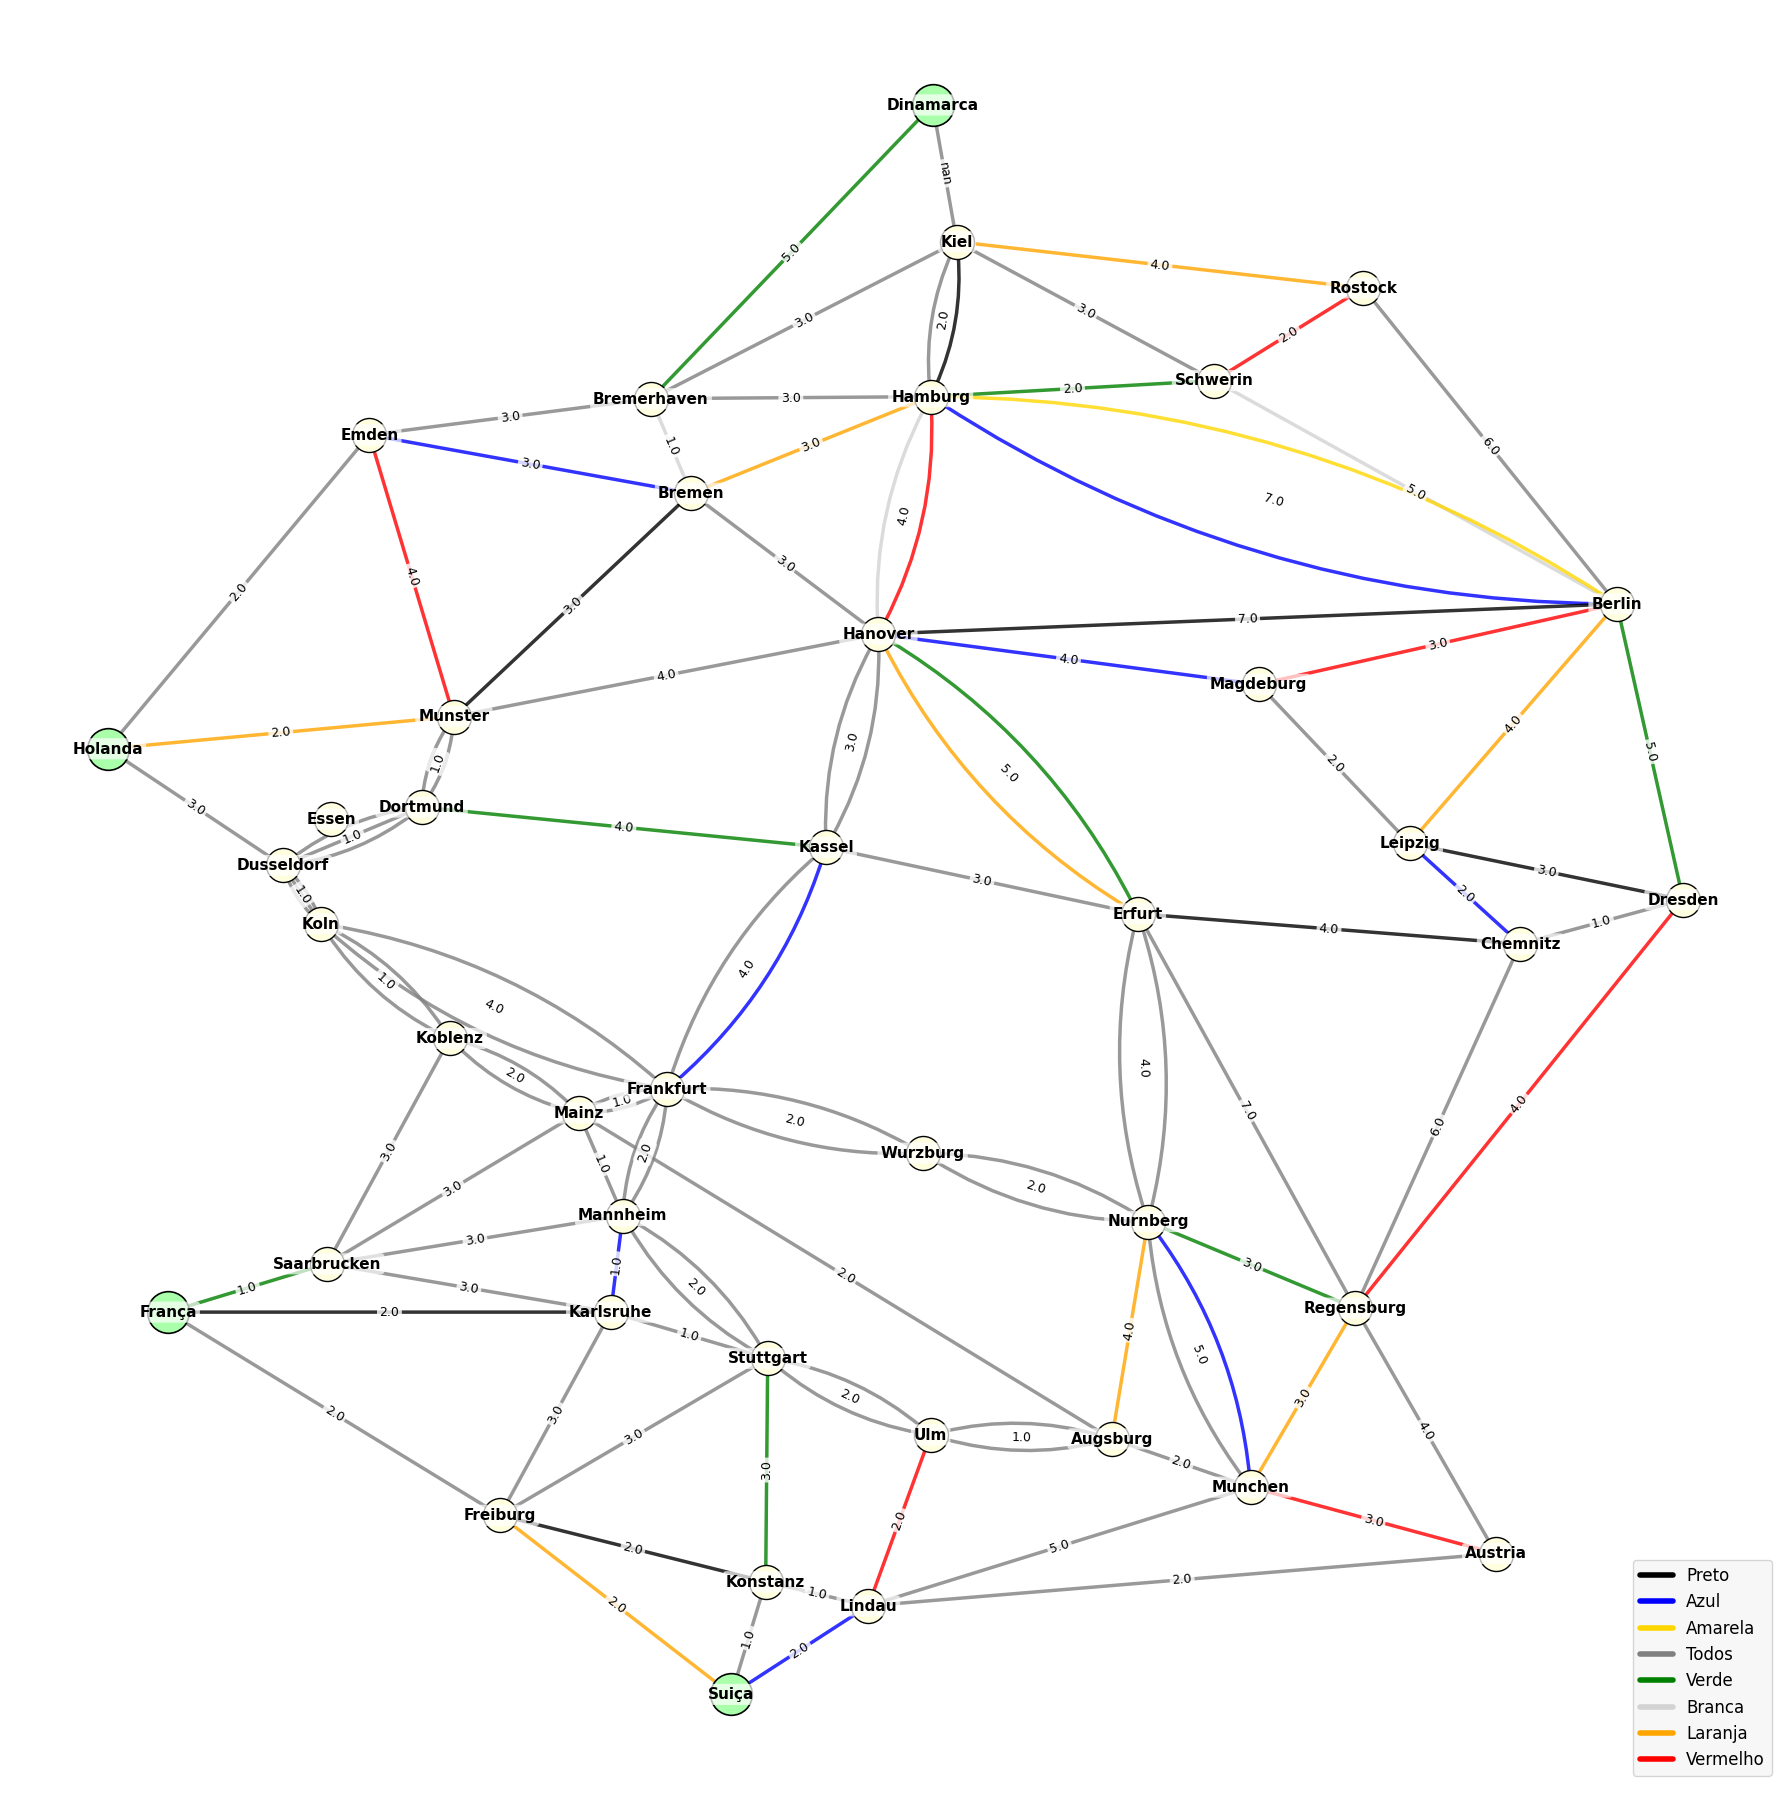

In [ ]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict

# --- Carregamento e Preparação ---

try:
    df = pd.read_csv("ticket_to_ride_germany.csv")
    print("Colunas encontradas no arquivo:", df.columns)
except FileNotFoundError:
    print("Erro: O arquivo 'ticket_to_ride_germany.csv' não foi encontrado.")
    exit()

# Mapeamento de cores
color_map = {
    "Todos": "gray", "Verde": "green", "Preto": "black", "Preta": "black",
    "Rosa": "pink", "Amarela": "gold", "Laranja": "orange", "Branca": "lightgray",
    "Vermelha": "red", "Vermelho": "red", "Azul": "blue",
}

# --- COORDENADAS GEOGRÁFICAS (x=lon, y=lat) ---
city_coordinates = {
    'Kiel': (10.12, 54.32), 'Rostock': (12.14, 54.09), 'Schwerin': (11.40, 53.63),
    'Hamburg': (9.99, 53.55), 'Bremen': (8.80, 53.07), 'Bremerhaven': (8.60, 53.54),
    'Emden': (7.20, 53.36),
    'Hanover': (9.73, 52.37), 'Berlin': (13.40, 52.52), 'Magdeburg': (11.62, 52.12),
    'Munster': (7.62, 51.96),
    'Dortmund': (7.46, 51.51), 'Essen': (7.01, 51.45), 'Dusseldorf': (6.77, 51.22),
    'Koln': (6.96, 50.93), 'Kassel': (9.47, 51.31), 'Leipzig': (12.37, 51.33),
    'Dresden': (13.73, 51.05), 'Erfurt': (11.02, 50.98), 'Chemnitz': (12.92, 50.83),
    'Koblenz': (7.60, 50.36),
    'Frankfurt': (8.68, 50.11), 'Mainz': (8.24, 49.99), 'Wurzburg': (9.95, 49.79),
    'Nurnberg': (11.07, 49.45), 'Regensburg': (12.10, 49.02), 'Mannheim': (8.46, 49.48),
    'Karlsruhe': (8.40, 49.00), 'Saarbrucken': (6.99, 49.24), 'Stuttgart': (9.18, 48.77),
    'Ulm': (9.99, 48.39), 'Augsburg': (10.89, 48.37), 'Munchen': (11.58, 48.13),
    'Lindau': (9.68, 47.54), 'Freiburg': (7.85, 47.99), 'Konstanz': (9.17, 47.66),
    # Países vizinhos
    'Dinamarca': (10.0, 55.0), 'França': (6.2, 49.0), 'Suiça': (9.0, 47.1),
    'Austria': (12.8, 47.8), 'Holanda': (5.9, 51.8)
}

# --- Criação do Grafo ---
G = nx.MultiGraph()

for city in city_coordinates.keys():
    G.add_node(city)

# Adiciona rotas do CSV
for _, row in df.iterrows():
    origem = row["Origem"].strip()
    destino = row["Destino"].strip()
    cor = color_map.get(str(row["Cor"]).strip(), "gray")
    custo = row["Custo"]

    if origem not in G: G.add_node(origem)
    if destino not in G: G.add_node(destino)

    G.add_edge(origem, destino, custo=custo, cor=cor)

pos = city_coordinates.copy()
for node in G.nodes():
    if node not in pos:
        print(f"Aviso: Coordenadas não encontradas para '{node}'. Posicionando aleatoriamente.")
        pos[node] = (np.random.uniform(6, 14), np.random.uniform(47, 55))

# --- Visualização ---
plt.figure(figsize=(18, 24))

country_names = ['Dinamarca', 'França', 'Suiça', 'Áustria', 'Holanda']
german_cities = [n for n in G.nodes if n not in country_names]
country_nodes = [n for n in country_names if n in G.nodes]

nx.draw_networkx_nodes(G, pos, nodelist=german_cities, node_size=600, node_color="lightyellow", edgecolors="black", linewidths=1.0)
nx.draw_networkx_nodes(G, pos, nodelist=country_nodes, node_size=900, node_color="#aaffaa", edgecolors="black", linewidths=1.2)

nx.draw_networkx_labels(G, pos, font_size=11, font_weight="bold", font_color="black",
                       bbox=dict(facecolor="white", alpha=0.7, edgecolor="none", boxstyle="round,pad=0.2"))

parallel_edges = defaultdict(list)
for u, v, data in G.edges(data=True):
    parallel_edges[tuple(sorted((u, v)))].append((u, v, data))

edge_labels = {}
for edge_group in parallel_edges.values():
    if len(edge_group) == 1:
        u, v, data = edge_group[0]
        nx.draw_networkx_edges(G, pos, edgelist=[(u, v)], width=2.5, edge_color=data["cor"], alpha=0.8)
        edge_labels[(u, v)] = data.get("custo", "")
    else:
        rads = np.linspace(-0.15, 0.15, len(edge_group))
        for rad, (u, v, data) in zip(rads, edge_group):
            nx.draw_networkx_edges(G, pos, edgelist=[(u, v)], width=2.5, edge_color=data["cor"], alpha=0.8,
                                   connectionstyle=f"arc3,rad={rad}")
        u_label, v_label, data_label = edge_group[0]
        edge_labels[(u_label, v_label)] = data_label.get("custo", "")

nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=9, font_color="black",
                             bbox=dict(facecolor="white", alpha=0.8, edgecolor="none", boxstyle="round,pad=0.2"))

cores_usadas = sorted(list(set(nx.get_edge_attributes(G, "cor").values())))
nomes_unicos = {}
for nome, cor in color_map.items():
    if cor not in nomes_unicos: nomes_unicos[cor] = nome
nomes_unicos['black'] = 'Preto'
nomes_unicos['red'] = 'Vermelho'

handles = [plt.Line2D([0], [0], color=c, lw=4, solid_capstyle="round") for c in cores_usadas]
labels = [nomes_unicos[c] for c in cores_usadas]
plt.legend(handles, labels, fontsize=12, title_fontsize=14,
           loc="lower right", frameon=True, facecolor="whitesmoke")

plt.gca().set_aspect("equal", adjustable="box")
plt.axis("off")
plt.tight_layout()
plt.savefig("mapa_ticket_to_ride_alemanha_final.pdf", format='pdf', bbox_inches="tight")
plt.show()

# USA Map

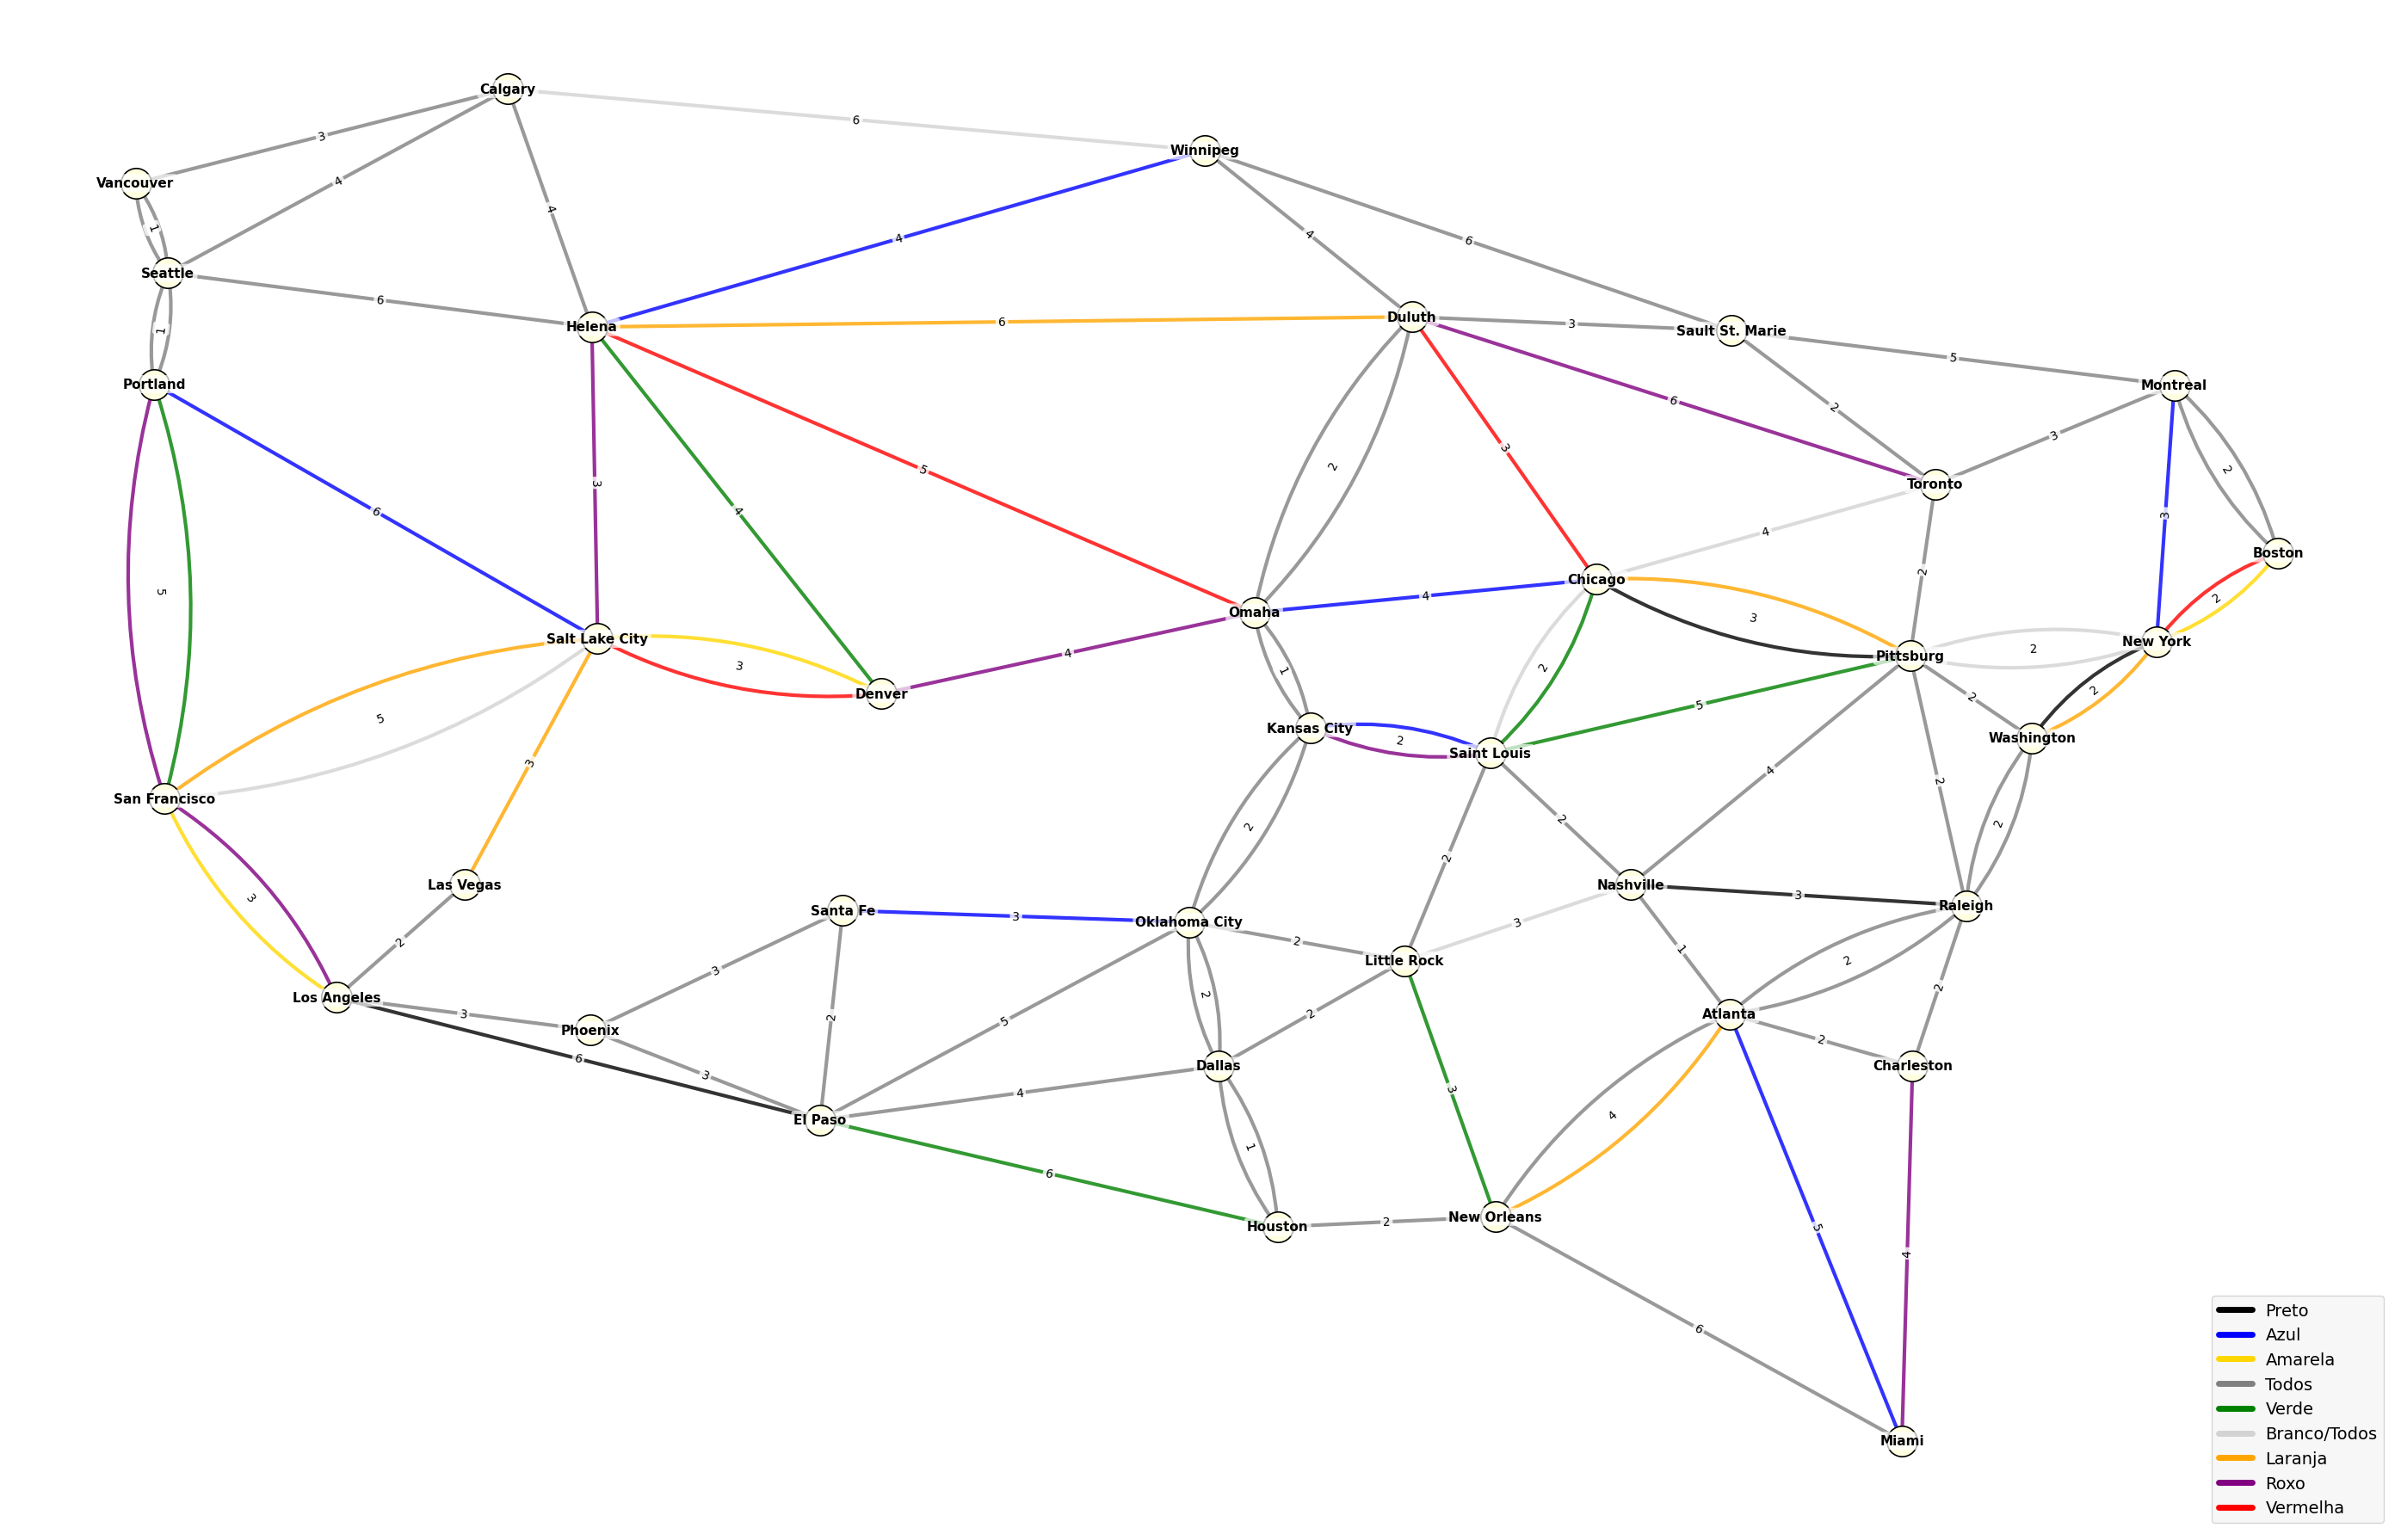

In [ ]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict

# --- 1. Leitura e Preparação dos Dados ---
# Lendo diretamente do arquivo CSV, como solicitado.
try:
    df = pd.read_csv("ticket_to_ride_north_america.csv")
except FileNotFoundError:
    print("Erro: O arquivo 'ticket_to_ride_north_america.csv' não foi encontrado.")
    print("Por favor, certifique-se de que o nome está correto e o arquivo está na mesma pasta.")
    exit()

# CORREÇÃO DE DADOS: "Saint Pauls" é um erro de digitação comum para "Saint Louis"
df.replace("Saint Pauls", "Saint Louis", inplace=True)

# Mapeamento de cores
color_map = {
    "Todos": "gray", "Verde": "green", "Preto": "black", "Branca": "lightgray",
    "Rosa": "pink", "Amarela": "gold", "Laranja": "orange", "Azul": "blue",
    "Vermelha": "red", "Roxa": "purple", "Branco": "lightgray"
}

# --- 2. COORDENADAS GEOGRÁFICAS (x=lon, y=lat) ---
city_coordinates = {
    'Vancouver': (-123.12, 49.28), 'Calgary': (-114.07, 51.04), 'Winnipeg': (-97.13, 49.89),
    'Seattle': (-122.33, 47.60), 'Portland': (-122.67, 45.52), 'Helena': (-112.03, 46.59),
    'Sault St. Marie': (-84.33, 46.52), 'Montreal': (-73.57, 45.50), 'Toronto': (-79.38, 43.65),
    'Duluth': (-92.10, 46.78), 'Omaha': (-95.93, 41.25), 'Denver': (-104.99, 39.73),
    'Salt Lake City': (-111.89, 40.76), 'San Francisco': (-122.41, 37.77),
    'Los Angeles': (-118.24, 34.05), 'Las Vegas': (-115.13, 36.16), 'Phoenix': (-112.07, 33.44),
    'Santa Fe': (-105.93, 35.68), 'El Paso': (-106.48, 31.76), 'Kansas City': (-94.57, 39.09),
    'Oklahoma City': (-97.51, 35.46), 'Dallas': (-96.79, 32.77), 'Houston': (-95.36, 29.76),
    'Chicago': (-87.62, 41.87), 'Saint Louis': (-90.19, 38.62), 'Little Rock': (-92.28, 34.74),
    'New Orleans': (-90.07, 29.95), 'Pittsburg': (-79.99, 40.44), 'Nashville': (-86.78, 36.16),
    'Atlanta': (-84.38, 33.74), 'Boston': (-71.05, 42.36), 'New York': (-74.00, 40.71),
    'Washington': (-77.03, 38.90), 'Raleigh': (-78.63, 35.77), 'Charleston': (-79.93, 32.77),
    'Miami': (-80.19, 25.76)
}

# --- 3. Criação do Grafo ---
G = nx.MultiGraph()

for city in city_coordinates.keys():
    G.add_node(city)

for _, row in df.iterrows():
    origem = row["Origem"].strip()
    destino = row["Destino"].strip()
    cor = color_map.get(str(row["Cor"]).strip(), "gray")
    custo = row["Custo"]

    if origem not in G: G.add_node(origem)
    if destino not in G: G.add_node(destino)
    G.add_edge(origem, destino, custo=custo, cor=cor)

pos = city_coordinates

# --- 4. Visualização Otimizada ---
# AUMENTO DO TAMANHO da figura para dar mais espaço aos elementos
plt.figure(figsize=(28, 19))

# Nós (um pouco maiores para melhor legibilidade)
nx.draw_networkx_nodes(G, pos, nodelist=G.nodes(),
                       node_size=650, node_color="lightyellow",
                       edgecolors="black", linewidths=1.2)

# Rótulos (fontes um pouco maiores)
nx.draw_networkx_labels(G, pos, font_size=11, font_weight="bold",
                       bbox=dict(facecolor="white", alpha=0.7, edgecolor="none", boxstyle="round,pad=0.2"))

# Arestas
parallel_edges = defaultdict(list)
for u, v, data in G.edges(data=True):
    parallel_edges[tuple(sorted((u, v)))].append((u, v, data))

edge_labels = {}
for edge_group in parallel_edges.values():
    if len(edge_group) == 1:
        u, v, data = edge_group[0]
        nx.draw_networkx_edges(G, pos, edgelist=[(u, v)], width=3.0,
                               edge_color=data["cor"], alpha=0.8)
        edge_labels[(u, v)] = data.get("custo", "")
    else:
        rads = np.linspace(-0.15, 0.15, len(edge_group))
        for rad, (u, v, data) in zip(rads, edge_group):
            nx.draw_networkx_edges(G, pos, edgelist=[(u, v)], width=3.0,
                                   edge_color=data["cor"], alpha=0.8,
                                   connectionstyle=f"arc3,rad={rad}")
        u_label, v_label, data_label = edge_group[0]
        edge_labels[(u_label, v_label)] = data_label.get("custo", "")

# Custos nas arestas
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels,
                             font_size=10, font_color="black",
                             bbox=dict(facecolor="white", alpha=0.8, edgecolor="none", boxstyle="round,pad=0.2"))

# Legenda
cores_usadas = sorted(list(set(nx.get_edge_attributes(G, "cor").values())))
nomes_unicos = {cor: nome for nome, cor in color_map.items()} # Simplificado
nomes_unicos['purple'] = 'Roxo'
nomes_unicos['lightgray'] = 'Branco/Todos'

handles = [plt.Line2D([0], [0], color=c, lw=5, solid_capstyle="round") for c in cores_usadas]
labels = [nomes_unicos[c] for c in cores_usadas]
plt.legend(handles, labels, fontsize=14, title_fontsize=16,
           loc="lower right", frameon=True, facecolor="whitesmoke")

# CORREÇÃO DA PROPORÇÃO para evitar o mapa "achatado"
ax = plt.gca()
ax.set_aspect(1.3, adjustable='box')
ax.axis("off")

plt.tight_layout()
# AUMENTO DA RESOLUÇÃO da imagem salva
plt.savefig("mapa_ticket_to_ride_america_final.pdf", format='pdf', bbox_inches="tight")
plt.show()

# Minimum Spanning Tree

We use the minimum spanning tree to estimate the total resources required to cover the entire board. This approach provides insights into the structure and distribution of cost-efficient routes, enabling faster and more informed decision-making. Since objectives are randomly assigned in a competitive setting, the MST serves as a useful heuristic for guiding strategic choices.

In [1]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

# --- 1. CONFIGURAÇÃO E CARREGAMENTO DOS DADOS ---

# Escolha qual mapa analisar: 'america' ou 'alemanha'
mapa_escolhido = 'alemanha' # O erro ocorreu com os dados da Alemanha

# Dicionários com as coordenadas geográficas de cada mapa
coordenadas_america = {
    'Vancouver': (-123.12, 49.28), 'Calgary': (-114.07, 51.04), 'Winnipeg': (-97.13, 49.89),
    'Seattle': (-122.33, 47.60), 'Portland': (-122.67, 45.52), 'Helena': (-112.03, 46.59),
    'Sault St. Marie': (-84.33, 46.52), 'Montreal': (-73.57, 45.50), 'Toronto': (-79.38, 43.65),
    'Duluth': (-92.10, 46.78), 'Omaha': (-95.93, 41.25), 'Denver': (-104.99, 39.73),
    'Salt Lake City': (-111.89, 40.76), 'San Francisco': (-122.41, 37.77),
    'Los Angeles': (-118.24, 34.05), 'Las Vegas': (-115.13, 36.16), 'Phoenix': (-112.07, 33.44),
    'Santa Fe': (-105.93, 35.68), 'El Paso': (-106.48, 31.76), 'Kansas City': (-94.57, 39.09),
    'Oklahoma City': (-97.51, 35.46), 'Dallas': (-96.79, 32.77), 'Houston': (-95.36, 29.76),
    'Chicago': (-87.62, 41.87), 'Saint Louis': (-90.19, 38.62), 'Little Rock': (-92.28, 34.74),
    'New Orleans': (-90.07, 29.95), 'Pittsburg': (-79.99, 40.44), 'Nashville': (-86.78, 36.16),
    'Atlanta': (-84.38, 33.74), 'Boston': (-71.05, 42.36), 'New York': (-74.00, 40.71),
    'Washington': (-77.03, 38.90), 'Raleigh': (-78.63, 35.77), 'Charleston': (-79.93, 32.77),
    'Miami': (-80.19, 25.76)
}

coordenadas_alemanha = {
    'Kiel': (10.12, 54.32), 'Rostock': (12.14, 54.09), 'Schwerin': (11.40, 53.63),
    'Hamburg': (9.99, 53.55), 'Bremen': (8.80, 53.07), 'Bremerhaven': (8.60, 53.54),
    'Emden': (7.20, 53.36), 'Hanover': (9.73, 52.37), 'Berlin': (13.40, 52.52),
    'Magdeburg': (11.62, 52.12), 'Munster': (7.62, 51.96), 'Dortmund': (7.46, 51.51),
    'Essen': (7.01, 51.45), 'Dusseldorf': (6.77, 51.22), 'Koln': (6.96, 50.93),
    'Kassel': (9.47, 51.31), 'Leipzig': (12.37, 51.33), 'Dresden': (13.73, 51.05),
    'Erfurt': (11.02, 50.98), 'Chemnitz': (12.92, 50.83), 'Koblenz': (7.60, 50.36),
    'Frankfurt': (8.68, 50.11), 'Mainz': (8.24, 49.99), 'Wurzburg': (9.95, 49.79),
    'Nurnberg': (11.07, 49.45), 'Regensburg': (12.10, 49.02), 'Mannheim': (8.46, 49.48),
    'Karlsruhe': (8.40, 49.00), 'Saarbrucken': (6.99, 49.24), 'Stuttgart': (9.18, 48.77),
    'Ulm': (9.99, 48.39), 'Augsburg': (10.89, 48.37), 'Munchen': (11.58, 48.13),
    'Lindau': (9.68, 47.54), 'Freiburg': (7.85, 47.99), 'Konstanz': (9.17, 47.66),
    'Dinamarca': (10.0, 55.0), 'França': (6.2, 49.0), 'Suiça': (9.0, 47.1),
    'Austria': (12.8, 47.8), 'Holanda': (5.9, 51.8)
}

# Seleciona os dados corretos com base na escolha
if mapa_escolhido == 'america':
    arquivo_csv = 'ticket_to_ride_north_america.csv'
    pos = coordenadas_america
    fig_size = (28, 19)
    aspect_ratio = 1.3
else:
    arquivo_csv = 'ticket_to_ride_germany.csv'
    pos = coordenadas_alemanha
    fig_size = (18, 24)
    aspect_ratio = 1.0

try:
    df = pd.read_csv(arquivo_csv)

    # --- CORREÇÃO ADICIONADA AQUI ---
    # Remove qualquer linha onde a coluna 'Custo' esteja vazia (NaN)
    df.dropna(subset=['Custo'], inplace=True)
    # Garante que todos os custos sejam números inteiros
    df['Custo'] = df['Custo'].astype(int)

    # Correções de dados específicas para cada mapa
    if mapa_escolhido == 'america':
        df.replace("Saint Pauls", "Saint Louis", inplace=True)

except FileNotFoundError:
    print(f"Erro: O arquivo '{arquivo_csv}' não foi encontrado.")
    exit()
except KeyError:
    print(f"Erro: Verifique se as colunas 'Origem', 'Destino' e 'Custo' existem no arquivo '{arquivo_csv}'.")
    exit()

# --- 2. CRIAÇÃO DO GRAFO E PREPARAÇÃO PARA MST ---

# Grafo completo com todas as rotas (MultiGraph)
G = nx.MultiGraph()
for _, row in df.iterrows():
    G.add_edge(row["Origem"].strip(), row["Destino"].strip(), custo=row["Custo"])

# Grafo simples para o cálculo da MST
H = nx.Graph()
for u, v, data in G.edges(data=True):
    custo = data['custo']
    if H.has_edge(u, v):
        if custo < H[u][v]['custo']:
            H[u][v]['custo'] = custo
    else:
        H.add_edge(u, v, custo=custo)

# --- 3. CÁLCULO DA ÁRVORE GERADORA MÍNIMA ---
MST = nx.minimum_spanning_tree(H, weight='custo')
custo_total = int(MST.size(weight='custo'))

# --- 4. VISUALIZAÇÃO ---
plt.figure(figsize=fig_size)
titulo_mapa = f"Minimum Spanning Tree (MST) - Map: {mapa_escolhido.title()}\nTotal Cost: {custo_total} Wagon"
plt.title(titulo_mapa, fontsize=22, fontweight='bold', pad=20)

nx.draw_networkx_nodes(G, pos, node_size=200, node_color='#cccccc')
nx.draw_networkx_edges(G, pos, width=1.0, edge_color='lightgray', alpha=0.8)

nx.draw_networkx_nodes(G, pos, nodelist=MST.nodes(),
                       node_size=600, node_color="skyblue",
                       edgecolors="black", linewidths=1.2)

nx.draw_networkx_edges(MST, pos, width=3.5, edge_color="red", alpha=0.9)

nx.draw_networkx_labels(G, pos, font_size=11, font_weight="bold",
                       bbox=dict(facecolor="white", alpha=0.6, edgecolor="none", boxstyle="round,pad=0.2"))

ax = plt.gca()
ax.set_aspect(aspect_ratio, adjustable='box')
ax.axis("off")
plt.tight_layout()
plt.savefig(f"mst_mapa_{mapa_escolhido}.png", dpi=300, bbox_inches="tight")
plt.show()

Erro: O arquivo 'ticket_to_ride_germany.csv' não foi encontrado.


NameError: name 'df' is not defined

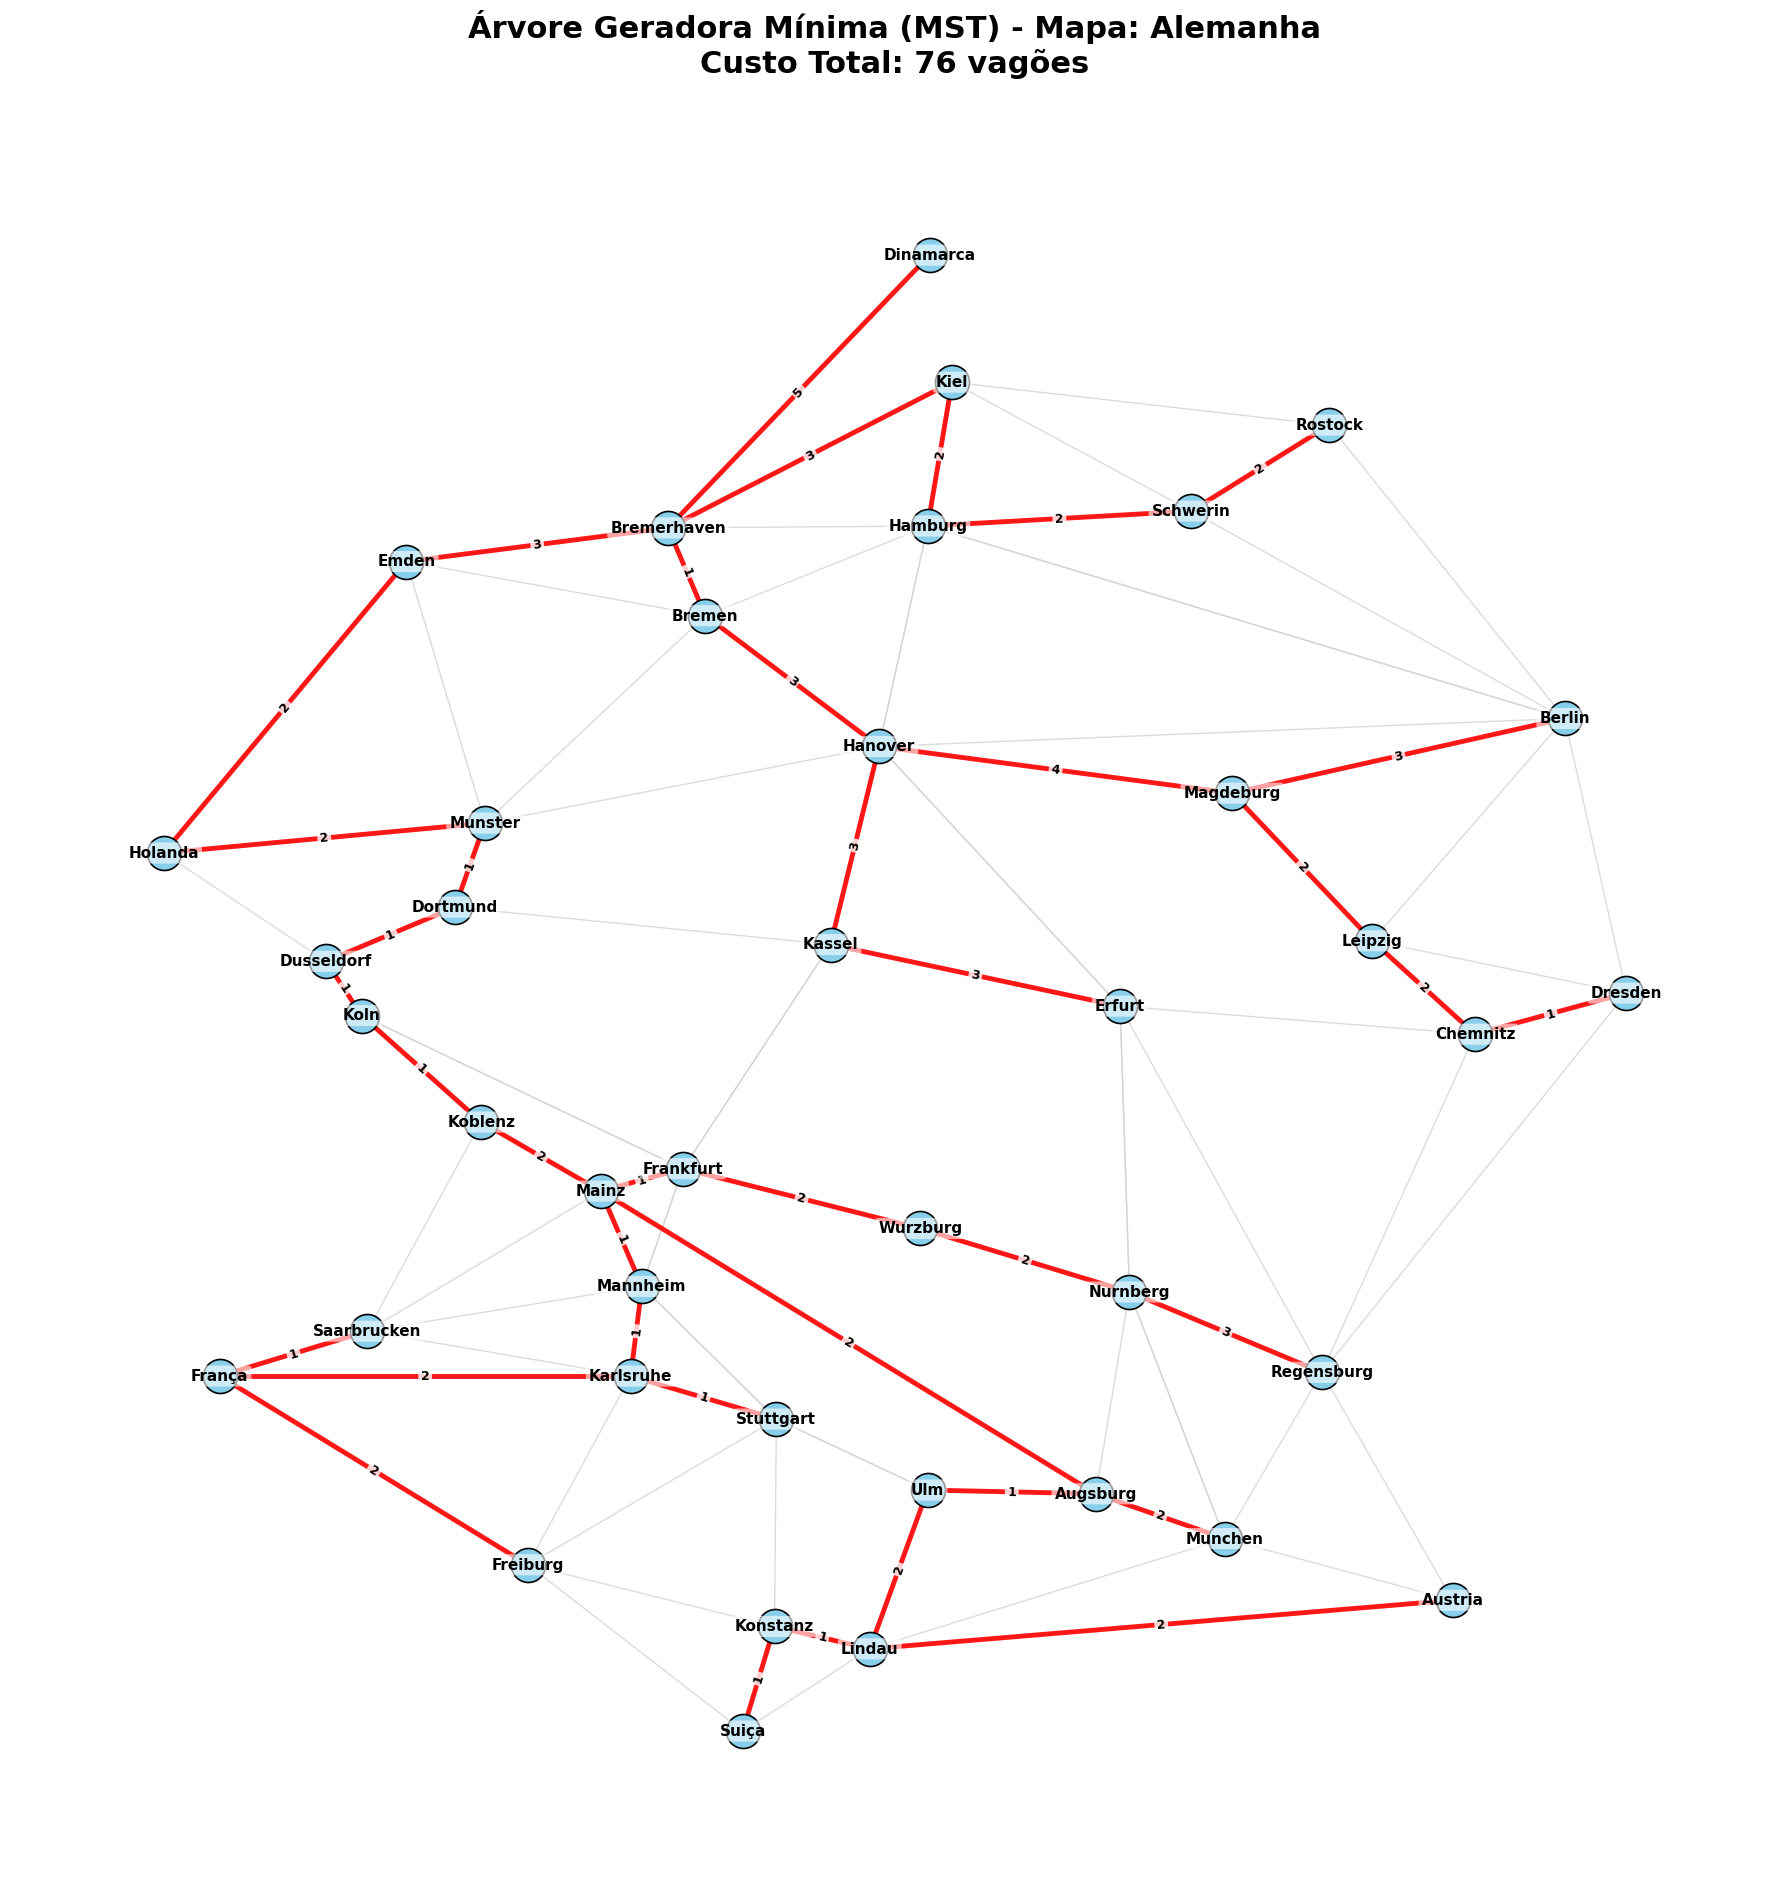

In [ ]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

# --- 1. CONFIGURAÇÃO E CARREGAMENTO DOS DADOS ---

# Escolha qual mapa analisar: 'america' ou 'alemanha'
mapa_escolhido = 'alemanha'

# Dicionários com as coordenadas geográficas de cada mapa
coordenadas_america = {
    'Vancouver': (-123.12, 49.28), 'Calgary': (-114.07, 51.04), 'Winnipeg': (-97.13, 49.89),
    'Seattle': (-122.33, 47.60), 'Portland': (-122.67, 45.52), 'Helena': (-112.03, 46.59),
    'Sault St. Marie': (-84.33, 46.52), 'Montreal': (-73.57, 45.50), 'Toronto': (-79.38, 43.65),
    'Duluth': (-92.10, 46.78), 'Omaha': (-95.93, 41.25), 'Denver': (-104.99, 39.73),
    'Salt Lake City': (-111.89, 40.76), 'San Francisco': (-122.41, 37.77),
    'Los Angeles': (-118.24, 34.05), 'Las Vegas': (-115.13, 36.16), 'Phoenix': (-112.07, 33.44),
    'Santa Fe': (-105.93, 35.68), 'El Paso': (-106.48, 31.76), 'Kansas City': (-94.57, 39.09),
    'Oklahoma City': (-97.51, 35.46), 'Dallas': (-96.79, 32.77), 'Houston': (-95.36, 29.76),
    'Chicago': (-87.62, 41.87), 'Saint Louis': (-90.19, 38.62), 'Little Rock': (-92.28, 34.74),
    'New Orleans': (-90.07, 29.95), 'Pittsburg': (-79.99, 40.44), 'Nashville': (-86.78, 36.16),
    'Atlanta': (-84.38, 33.74), 'Boston': (-71.05, 42.36), 'New York': (-74.00, 40.71),
    'Washington': (-77.03, 38.90), 'Raleigh': (-78.63, 35.77), 'Charleston': (-79.93, 32.77),
    'Miami': (-80.19, 25.76)
}

coordenadas_alemanha = {
    'Kiel': (10.12, 54.32), 'Rostock': (12.14, 54.09), 'Schwerin': (11.40, 53.63),
    'Hamburg': (9.99, 53.55), 'Bremen': (8.80, 53.07), 'Bremerhaven': (8.60, 53.54),
    'Emden': (7.20, 53.36), 'Hanover': (9.73, 52.37), 'Berlin': (13.40, 52.52),
    'Magdeburg': (11.62, 52.12), 'Munster': (7.62, 51.96), 'Dortmund': (7.46, 51.51),
    'Essen': (7.01, 51.45), 'Dusseldorf': (6.77, 51.22), 'Koln': (6.96, 50.93),
    'Kassel': (9.47, 51.31), 'Leipzig': (12.37, 51.33), 'Dresden': (13.73, 51.05),
    'Erfurt': (11.02, 50.98), 'Chemnitz': (12.92, 50.83), 'Koblenz': (7.60, 50.36),
    'Frankfurt': (8.68, 50.11), 'Mainz': (8.24, 49.99), 'Wurzburg': (9.95, 49.79),
    'Nurnberg': (11.07, 49.45), 'Regensburg': (12.10, 49.02), 'Mannheim': (8.46, 49.48),
    'Karlsruhe': (8.40, 49.00), 'Saarbrucken': (6.99, 49.24), 'Stuttgart': (9.18, 48.77),
    'Ulm': (9.99, 48.39), 'Augsburg': (10.89, 48.37), 'Munchen': (11.58, 48.13),
    'Lindau': (9.68, 47.54), 'Freiburg': (7.85, 47.99), 'Konstanz': (9.17, 47.66),
    'Dinamarca': (10.0, 55.0), 'França': (6.2, 49.0), 'Suiça': (9.0, 47.1),
    'Austria': (12.8, 47.8), 'Holanda': (5.9, 51.8)
}

# Seleciona os dados corretos com base na escolha
if mapa_escolhido == 'america':
    arquivo_csv = 'ticket_to_ride_north_america.csv'
    pos = coordenadas_america
    fig_size = (28, 19)
    aspect_ratio = 1.3
else:
    arquivo_csv = 'ticket_to_ride_germany.csv'
    pos = coordenadas_alemanha
    fig_size = (18, 24)
    aspect_ratio = 1.0

try:
    df = pd.read_csv(arquivo_csv)
    df.dropna(subset=['Custo'], inplace=True)
    df['Custo'] = df['Custo'].astype(int)
    if mapa_escolhido == 'america':
        df.replace("Saint Pauls", "Saint Louis", inplace=True)
except FileNotFoundError:
    print(f"Erro: O arquivo '{arquivo_csv}' não foi encontrado.")
    exit()
except KeyError:
    print(f"Erro: Verifique se as colunas 'Origem', 'Destino' e 'Custo' existem no arquivo '{arquivo_csv}'.")
    exit()

# --- 2. CRIAÇÃO DO GRAFO E PREPARAÇÃO PARA MST ---

G = nx.MultiGraph()
for _, row in df.iterrows():
    G.add_edge(row["Origem"].strip(), row["Destino"].strip(), custo=row["Custo"])

H = nx.Graph()
for u, v, data in G.edges(data=True):
    custo = data['custo']
    if H.has_edge(u, v):
        if custo < H[u][v]['custo']:
            H[u][v]['custo'] = custo
    else:
        H.add_edge(u, v, custo=custo)

# --- 3. CÁLCULO DA ÁRVORE GERADORA MÍNIMA ---
MST = nx.minimum_spanning_tree(H, weight='custo')
custo_total = int(MST.size(weight='custo'))

# --- 4. VISUALIZAÇÃO ---
plt.figure(figsize=fig_size)
titulo_mapa = f"Árvore Geradora Mínima (MST) - Mapa: {mapa_escolhido.title()}\nCusto Total: {custo_total} vagões"
plt.title(titulo_mapa, fontsize=22, fontweight='bold', pad=20)

# a) Desenha o mapa completo de fundo
nx.draw_networkx_nodes(G, pos, node_size=200, node_color='#cccccc')
nx.draw_networkx_edges(G, pos, width=1.0, edge_color='lightgray', alpha=0.8)

# b) Destaca os nós da MST
nx.draw_networkx_nodes(G, pos, nodelist=MST.nodes(),
                       node_size=600, node_color="skyblue",
                       edgecolors="black", linewidths=1.2)

# c) Desenha as arestas da MST
nx.draw_networkx_edges(MST, pos, width=3.5, edge_color="red", alpha=0.9)

# d) Adiciona os nomes de todas as cidades
nx.draw_networkx_labels(G, pos, font_size=11, font_weight="bold",
                       bbox=dict(facecolor="white", alpha=0.6, edgecolor="none", boxstyle="round,pad=0.2"))

# --- ADICIONADO: Desenha os custos das arestas da MST ---
# e) Prepara e desenha os rótulos de custo apenas para as arestas da MST
mst_edge_labels = nx.get_edge_attributes(MST, 'custo')
nx.draw_networkx_edge_labels(
    MST,
    pos,
    edge_labels=mst_edge_labels,
    font_size=9,
    font_color='black',
    font_weight='bold',
    bbox=dict(facecolor='white', alpha=0.8, edgecolor='none', boxstyle='round,pad=0.2')
)
# ---------------------------------------------------------

# Ajustes finais do plot
ax = plt.gca()
ax.set_aspect(aspect_ratio, adjustable='box')
ax.axis("off")
plt.tight_layout()
plt.savefig(f"mst_mapa_{mapa_escolhido}.png", dpi=300, bbox_inches="tight")
plt.show()

Iniciando o Algoritmo Genético...
Execução concluída após 15.00 segundos e 5820 gerações.


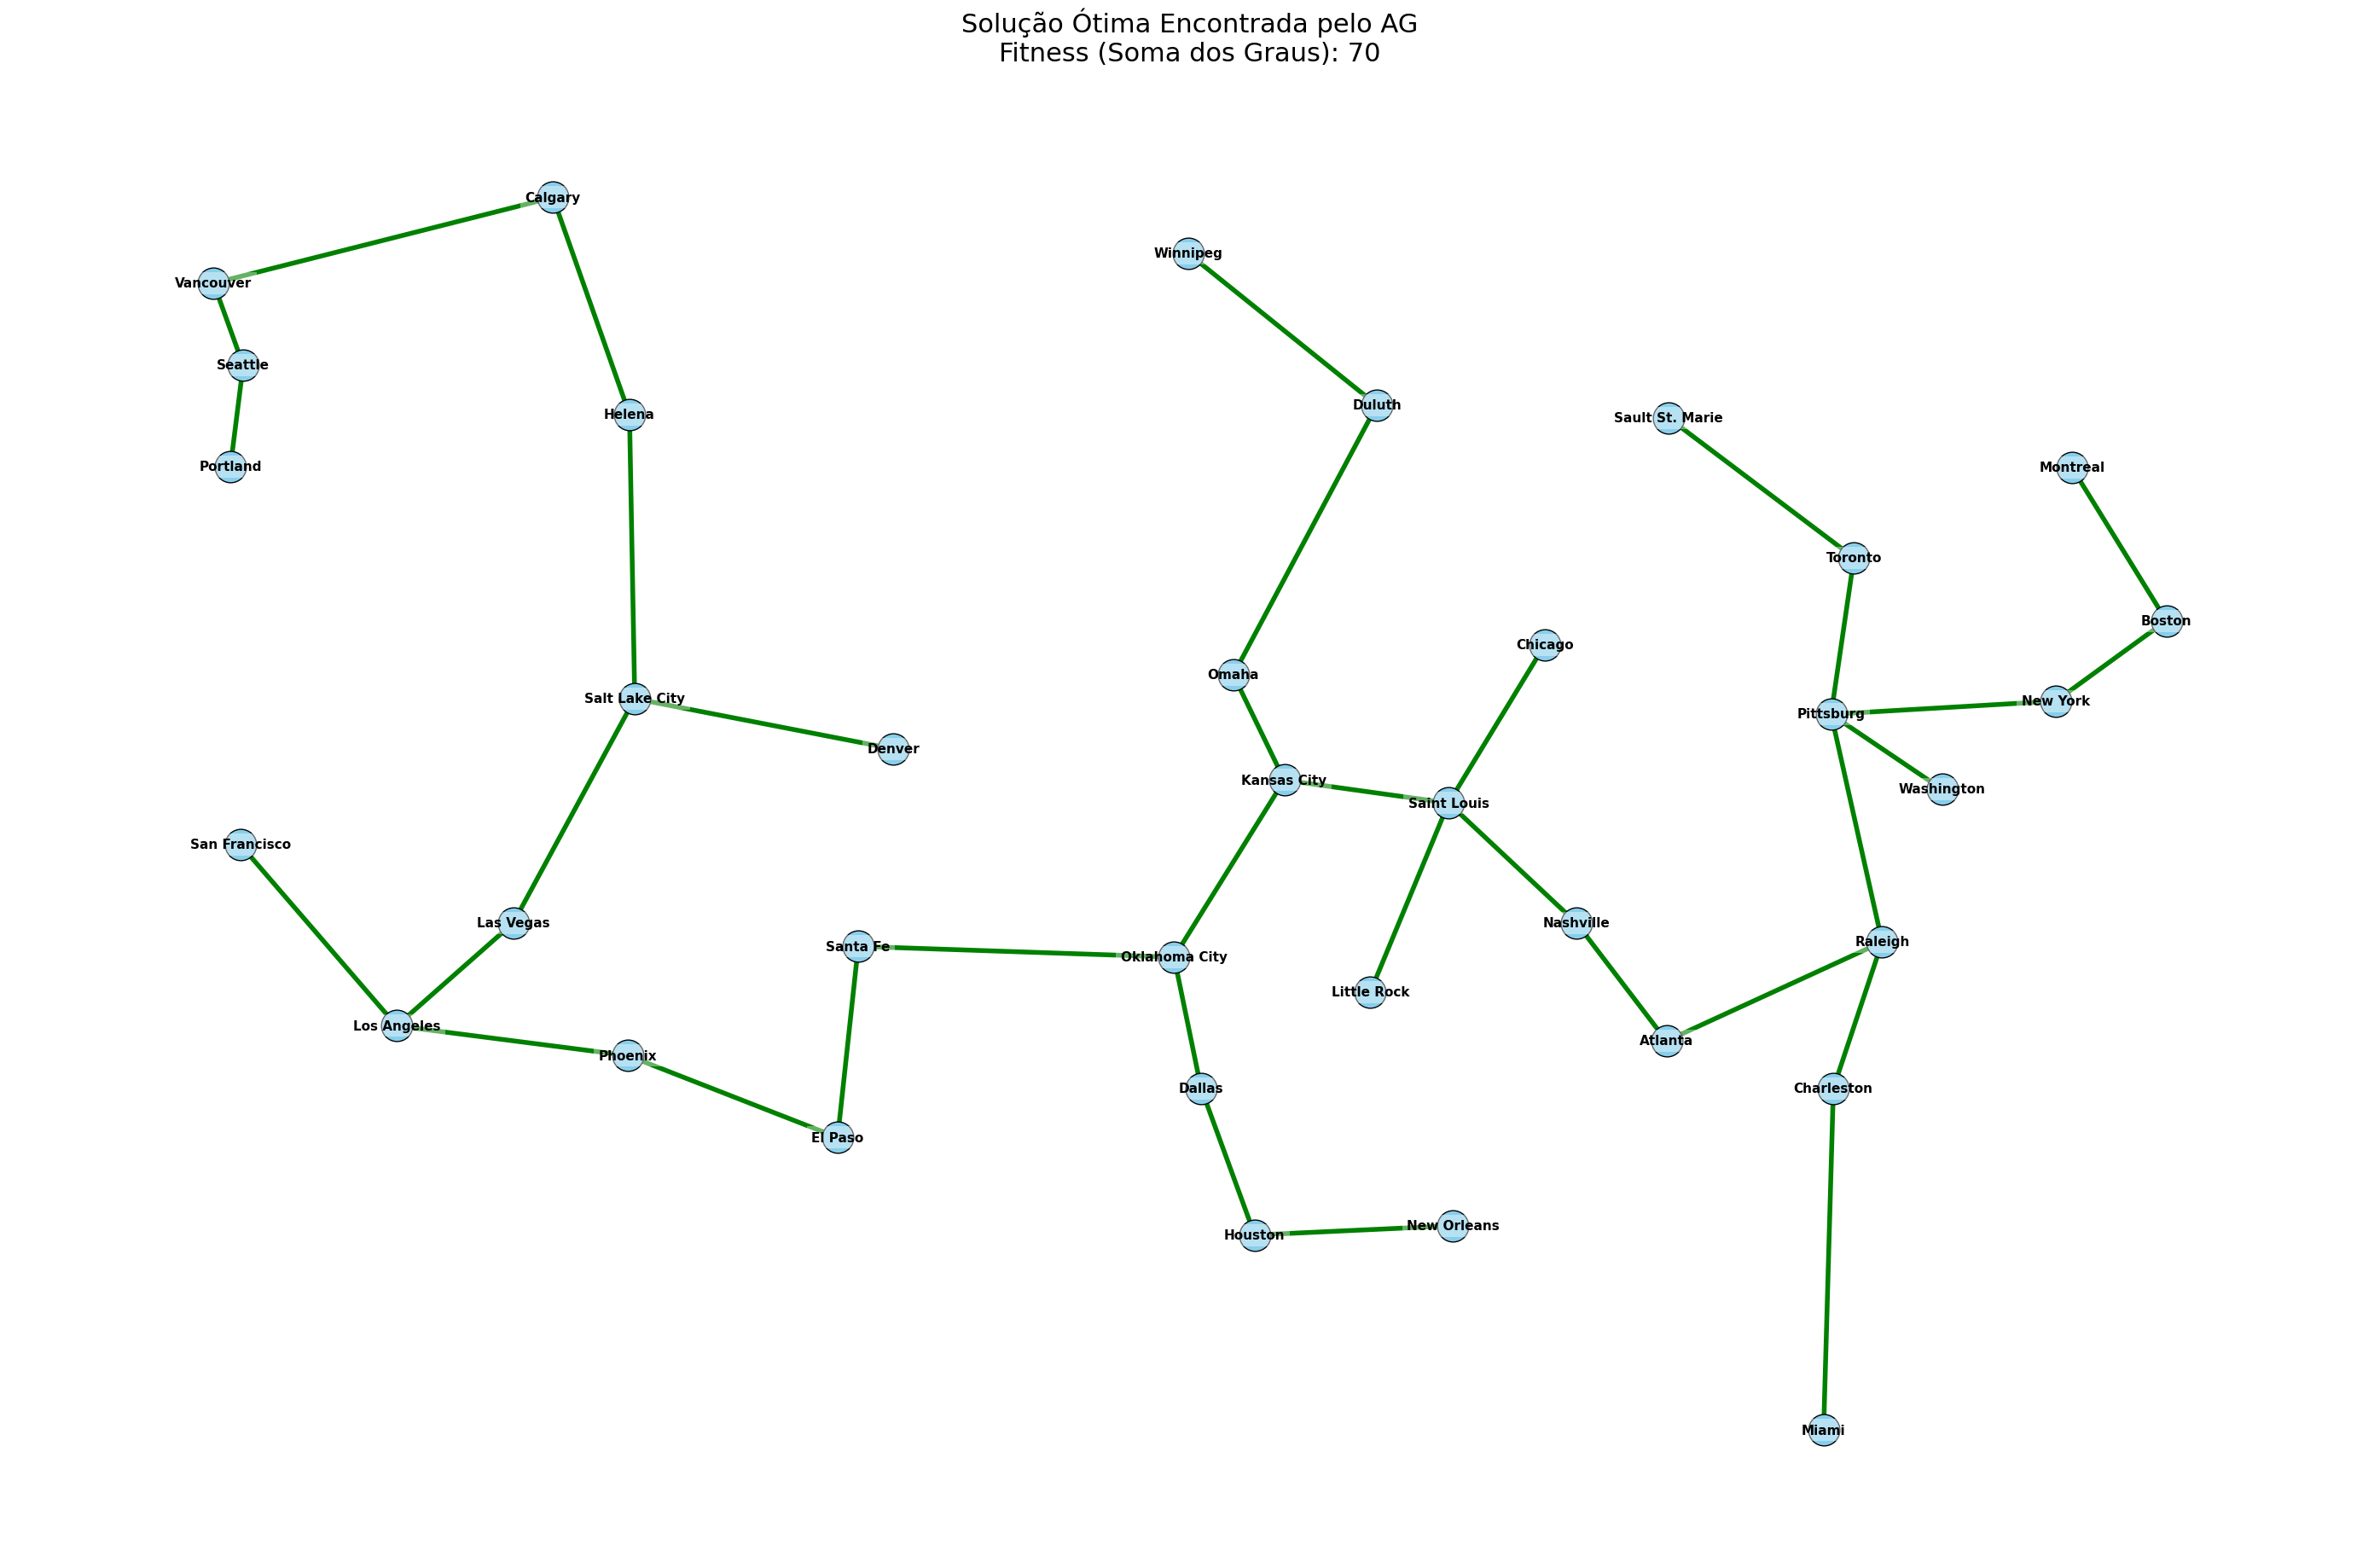

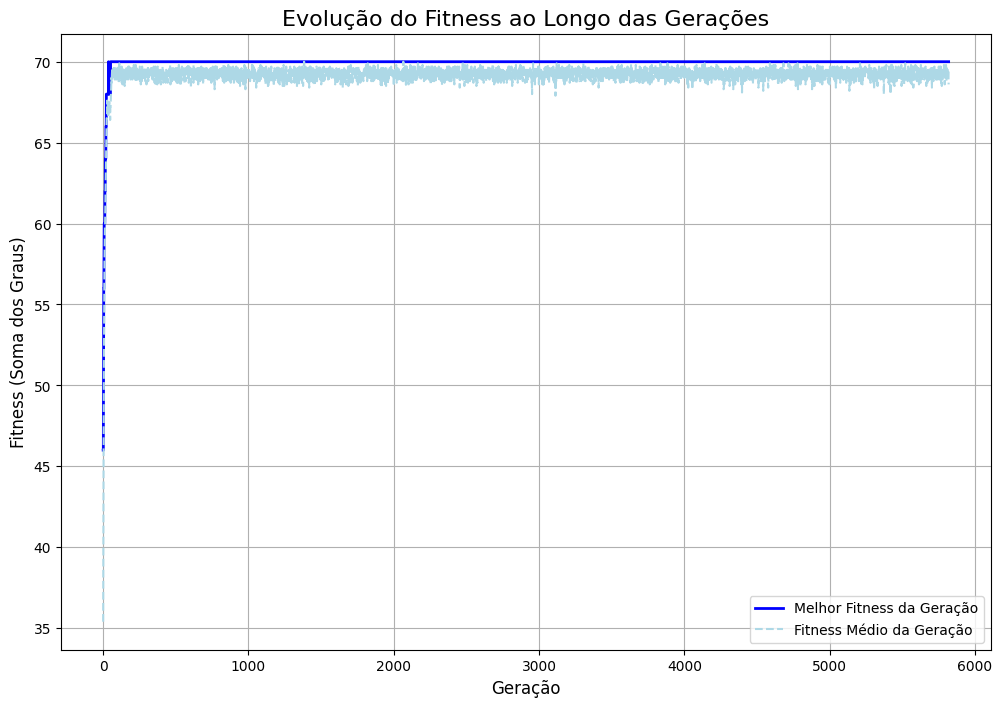

In [ ]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import time
import random

# --- 1. SETUP: CARREGAMENTO DE DADOS E CÁLCULO DA MST ---
# (Esta seção é uma versão condensada dos scripts anteriores)

def carregar_mst_do_mapa(mapa='america'):
    """Carrega os dados de um mapa, calcula e retorna sua MST e coordenadas."""
    coordenadas = {
        'america': {
            'Vancouver': (-123.12, 49.28), 'Calgary': (-114.07, 51.04), 'Winnipeg': (-97.13, 49.89),
            'Seattle': (-122.33, 47.60), 'Portland': (-122.67, 45.52), 'Helena': (-112.03, 46.59),
            'Sault St. Marie': (-84.33, 46.52), 'Montreal': (-73.57, 45.50), 'Toronto': (-79.38, 43.65),
            'Duluth': (-92.10, 46.78), 'Omaha': (-95.93, 41.25), 'Denver': (-104.99, 39.73),
            'Salt Lake City': (-111.89, 40.76), 'San Francisco': (-122.41, 37.77),
            'Los Angeles': (-118.24, 34.05), 'Las Vegas': (-115.13, 36.16), 'Phoenix': (-112.07, 33.44),
            'Santa Fe': (-105.93, 35.68), 'El Paso': (-106.48, 31.76), 'Kansas City': (-94.57, 39.09),
            'Oklahoma City': (-97.51, 35.46), 'Dallas': (-96.79, 32.77), 'Houston': (-95.36, 29.76),
            'Chicago': (-87.62, 41.87), 'Saint Louis': (-90.19, 38.62), 'Little Rock': (-92.28, 34.74),
            'New Orleans': (-90.07, 29.95), 'Pittsburg': (-79.99, 40.44), 'Nashville': (-86.78, 36.16),
            'Atlanta': (-84.38, 33.74), 'Boston': (-71.05, 42.36), 'New York': (-74.00, 40.71),
            'Washington': (-77.03, 38.90), 'Raleigh': (-78.63, 35.77), 'Charleston': (-79.93, 32.77),
            'Miami': (-80.19, 25.76)
        },
        'alemanha': {
             # Coordenadas da Alemanha (omitidas por brevidade, mas o código funcionaria)
        }
    }
    arquivo_csv = f'ticket_to_ride_{"north_america" if mapa == "america" else "germany"}.csv'

    df = pd.read_csv(arquivo_csv)
    df.dropna(subset=['Custo'], inplace=True)
    df['Custo'] = df['Custo'].astype(int)
    if mapa == 'america':
        df.replace("Saint Pauls", "Saint Louis", inplace=True)

    G = nx.MultiGraph()
    for _, row in df.iterrows():
        G.add_edge(row["Origem"].strip(), row["Destino"].strip(), custo=row["Custo"])

    H = nx.Graph()
    for u, v, data in G.edges(data=True):
        custo = data['custo']
        if H.has_edge(u, v):
            if custo < H[u][v]['custo']: H[u][v]['custo'] = custo
        else:
            H.add_edge(u, v, custo=custo)

    MST = nx.minimum_spanning_tree(H, weight='custo')
    return MST, coordenadas[mapa]

# --- 2. COMPONENTES DO ALGORITMO GENÉTICO ---

# Parâmetros do AG
POPULATION_SIZE = 20
MUTATION_RATE = 0.01
TOURNAMENT_SIZE = 3
EXECUTION_TIME_LIMIT = 15 # segundos

def create_individual(num_genes):
    """Cria um indivíduo aleatório (string binária)."""
    return [random.randint(0, 1) for _ in range(num_genes)]

def create_population(num_individuals, num_genes):
    """Cria a população inicial."""
    return [create_individual(num_genes) for _ in range(num_individuals)]

def calculate_fitness(individual, mst_edges):
    """Calcula a aptidão: soma dos graus do subgrafo."""
    subgraph = nx.Graph()
    selected_edges = [edge for i, edge in enumerate(mst_edges) if individual[i] == 1]

    if not selected_edges:
        return 0

    subgraph.add_edges_from(selected_edges)

    # A soma dos graus é a métrica a ser maximizada
    return sum(d for n, d in subgraph.degree())

def selection(population, fitnesses):
    """Seleção por torneio."""
    selected = []
    for _ in range(len(population)):
        tournament_indices = random.sample(range(len(population)), TOURNAMENT_SIZE)
        tournament_fitnesses = [fitnesses[i] for i in tournament_indices]
        winner_index = tournament_indices[np.argmax(tournament_fitnesses)]
        selected.append(population[winner_index])
    return selected

def crossover(parent1, parent2):
    """Crossover de ponto único."""
    if len(parent1) < 2: return parent1[:], parent2[:]
    point = random.randint(1, len(parent1) - 1)
    child1 = parent1[:point] + parent2[point:]
    child2 = parent2[:point] + parent1[point:]
    return child1, child2

def mutate(individual):
    """Mutação por inversão de bit."""
    for i in range(len(individual)):
        if random.random() < MUTATION_RATE:
            individual[i] = 1 - individual[i]
    return individual

# --- 3. EXECUÇÃO DO ALGORITMO GENÉTICO ---

print("Iniciando o Algoritmo Genético...")
# Carrega a MST do mapa da América do Norte
MST, pos = carregar_mst_do_mapa('america')
mst_edges = list(MST.edges())
num_genes = len(mst_edges)

# Cria a população inicial
population = create_population(POPULATION_SIZE, num_genes)

# Armazena o histórico de fitness para o gráfico de evolução
best_fitness_history = []
avg_fitness_history = []

start_time = time.time()
generation = 0

while (time.time() - start_time) < EXECUTION_TIME_LIMIT:
    generation += 1

    # 1. Calcula a aptidão de cada indivíduo
    fitnesses = [calculate_fitness(ind, mst_edges) for ind in population]

    # Armazena dados para o gráfico de evolução
    best_fitness_history.append(np.max(fitnesses))
    avg_fitness_history.append(np.mean(fitnesses))

    # 2. Seleciona os pais
    parents = selection(population, fitnesses)

    # 3. Cria a próxima geração
    next_population = []
    for i in range(0, POPULATION_SIZE, 2):
        parent1, parent2 = parents[i], parents[i+1]
        child1, child2 = crossover(parent1, parent2)
        next_population.append(mutate(child1))
        next_population.append(mutate(child2))

    population = next_population

print(f"Execução concluída após {time.time() - start_time:.2f} segundos e {generation} gerações.")

# --- 4. ANÁLISE E VISUALIZAÇÃO DOS RESULTADOS ---

# Encontra a melhor solução na população final
final_fitnesses = [calculate_fitness(ind, mst_edges) for ind in population]
best_individual = population[np.argmax(final_fitnesses)]
best_fitness = np.max(final_fitnesses)

# 1. GRÁFICO DA SOLUÇÃO ÓTIMA NO MAPA
plt.figure(figsize=(28, 19))
plt.title(f"Solução Ótima Encontrada pelo AG\nFitness (Soma dos Graus): {best_fitness}", fontsize=22)

# Desenha a MST completa de fundo
nx.draw_networkx_nodes(MST, pos, node_size=200, node_color='#cccccc')
nx.draw_networkx_edges(MST, pos, width=1.0, edge_color='lightgray', alpha=0.7)
nx.draw_networkx_labels(MST, pos, font_size=11, font_weight="bold",
                       bbox=dict(facecolor="white", alpha=0.4, edgecolor="none"))

# Constrói e desenha o subgrafo da melhor solução
best_subgraph = nx.Graph()
selected_edges = [edge for i, edge in enumerate(mst_edges) if best_individual[i] == 1]
best_subgraph.add_edges_from(selected_edges)

nx.draw_networkx_nodes(MST, pos, nodelist=best_subgraph.nodes(),
                       node_size=700, node_color="skyblue",
                       edgecolors="black")
nx.draw_networkx_edges(best_subgraph, pos, width=4.0, edge_color="green")

ax = plt.gca()
ax.set_aspect(1.3, adjustable='box')
ax.axis("off")
plt.tight_layout()
plt.savefig("ga_solucao_otima.png", dpi=300)
plt.show()


# 2. GRÁFICO DA EVOLUÇÃO DO FITNESS
plt.figure(figsize=(12, 8))
plt.plot(best_fitness_history, label="Melhor Fitness da Geração", color="blue", linewidth=2)
plt.plot(avg_fitness_history, label="Fitness Médio da Geração", color="lightblue", linestyle="--")
plt.title("Evolução do Fitness ao Longo das Gerações", fontsize=16)
plt.xlabel("Geração", fontsize=12)
plt.ylabel("Fitness (Soma dos Graus)", fontsize=12)
plt.legend()
plt.grid(True)
plt.savefig("ga_evolucao_fitness.png", dpi=300)
plt.show()

In [ ]:
import pandas as pd
import networkx as nx
import itertools
import numpy as np

# --- 1. CONFIGURAÇÃO E CARREGAMENTO DOS DADOS ---

def carregar_grafo_simples(mapa):
    """Carrega os dados e cria um grafo simples, usando o menor custo para rotas paralelas."""
    # ... (código da função anterior, sem alterações)
    if mapa == 'america':
        arquivo_csv = 'ticket_to_ride_north_america.csv'
    elif mapa == 'alemanha':
        arquivo_csv = 'ticket_to_ride_germany.csv'
    else:
        print(f"Erro: Mapa '{mapa}' não reconhecido. Escolha 'america' ou 'alemanha'.")
        return None
    try:
        df = pd.read_csv(arquivo_csv)
    except FileNotFoundError:
        print(f"Erro: O arquivo '{arquivo_csv}' não foi encontrado.")
        return None
    df.columns = [col.strip().title() for col in df.columns]
    df.dropna(subset=['Custo'], inplace=True)
    df['Custo'] = df['Custo'].astype(int)
    if mapa == 'america':
        df.replace("Saint Pauls", "Saint Louis", inplace=True)
    G = nx.Graph()
    for _, row in df.iterrows():
        u, v, custo = row["Origem"].strip(), row["Destino"].strip(), row["Custo"]
        if G.has_edge(u, v):
            if custo < G[u][v]['custo']: G[u][v]['custo'] = custo
        else:
            G.add_edge(u, v, custo=custo)
    return G

# --- 2. IMPLEMENTAÇÃO DOS ALGORITMOS DE BUSCA ---

def algoritmo_guloso_dfs(graph, start_node, end_node):
    # (código da função anterior, sem alterações)
    visited = {start_node}
    path = [start_node]
    total_cost = 0
    current_node = start_node
    while current_node != end_node:
        unvisited_neighbors = [n for n in graph.neighbors(current_node) if n not in visited]
        if not unvisited_neighbors: return None, np.inf
        best_next_node, min_cost = None, np.inf
        for neighbor in unvisited_neighbors:
            cost = graph[current_node][neighbor]['custo']
            if cost < min_cost:
                min_cost = cost
                best_next_node = neighbor
        if best_next_node is None: return None, np.inf
        total_cost += min_cost
        visited.add(best_next_node)
        path.append(best_next_node)
        current_node = best_next_node
    return path, total_cost

def algoritmo_dijkstra(graph, start_node, end_node):
    # (código da função anterior, sem alterações)
    try:
        cost = nx.dijkstra_path_length(graph, start_node, end_node, weight='custo')
        path = nx.dijkstra_path(graph, start_node, end_node, weight='custo')
        return path, cost
    except nx.NetworkXNoPath:
        return None, np.inf

def algoritmo_bfs(graph, start_node, end_node):
    """Encontra o caminho com o menor número de arestas (paradas) usando BFS."""
    try:
        path = nx.shortest_path(graph, source=start_node, target=end_node) # BFS é o default para grafos não ponderados
        # Calcula o custo do caminho encontrado pelo BFS
        cost = nx.path_weight(graph, path, weight='custo')
        return path, cost
    except nx.NetworkXNoPath:
        return None, np.inf

# --- 3. EXECUÇÃO DA ANÁLISE COMPARATIVA ---

mapa_escolhido = 'alemanha'
print(f"Carregando o mapa: {mapa_escolhido.title()}...")
G = carregar_grafo_simples(mapa_escolhido)

if G:
    nodes = list(G.nodes())
    all_pairs = list(itertools.combinations(nodes, 2))

    # Dicionário para armazenar todos os resultados
    results = []

    print(f"Analisando {len(all_pairs)} pares de cidades...")

    for i, (start, end) in enumerate(all_pairs):
        if (i + 1) % 100 == 0: print(f"  Processando par {i+1}/{len(all_pairs)}...")

        d_path, d_cost = algoritmo_dijkstra(G, start, end)
        b_path, b_cost = algoritmo_bfs(G, start, end)
        g_path, g_cost = algoritmo_guloso_dfs(G, start, end)

        results.append({
            'par': (start, end),
            'dijkstra_cost': d_cost, 'dijkstra_hops': len(d_path) - 1 if d_path else 0,
            'bfs_cost': b_cost, 'bfs_hops': len(b_path) - 1 if b_path else 0,
            'greedy_cost': g_cost, 'greedy_hops': len(g_path) - 1 if g_path else 0,
            'greedy_failed': g_path is None
        })

    # --- 4. CÁLCULO E EXIBIÇÃO DAS MÉTRICAS ---

    df_results = pd.DataFrame(results)
    df_valid = df_results[~df_results['greedy_failed']].copy() # Apenas comparações onde o guloso funcionou

    # Métricas de Performance
    dijkstra_wins_vs_greedy = (df_valid['dijkstra_cost'] < df_valid['greedy_cost']).sum()
    dijkstra_wins_vs_bfs = (df_valid['dijkstra_cost'] < df_valid['bfs_cost']).sum()
    bfs_wins_hops = (df_valid['bfs_hops'] < df_valid['dijkstra_hops']).sum()

    # Métricas de Custo
    avg_cost_dijkstra = df_valid['dijkstra_cost'].mean()
    avg_cost_bfs = df_valid['bfs_cost'].mean()
    avg_cost_greedy = df_valid['greedy_cost'].mean()

    # Piores Casos
    df_valid['bfs_inefficiency'] = df_valid['bfs_cost'] - df_valid['dijkstra_cost']
    df_valid['greedy_inefficiency'] = df_valid['greedy_cost'] - df_valid['dijkstra_cost']
    worst_case_bfs = df_valid.loc[df_valid['bfs_inefficiency'].idxmax()]
    worst_case_greedy = df_valid.loc[df_valid['greedy_inefficiency'].idxmax()]

    print("\n" + "="*50)
    print(f" ANÁLISE COMPARATIVA DE ALGORITMOS - MAPA: {mapa_escolhido.title()} ".center(50, "="))
    print("="*50 + "\n")

    print("--- RESUMO GERAL ---")
    print(f"Total de Pares de Cidades Analisados: {len(df_results)}")
    print(f"Falhas do Algoritmo Guloso (não encontrou caminho): {df_results['greedy_failed'].sum()}")
    print(f"Comparações Válidas (Guloso encontrou um caminho): {len(df_valid)}\n")

    print("--- COMPARAÇÃO DE CUSTO (Menor é Melhor) ---")
    print(f"Custo Médio por Rota (Dijkstra): {avg_cost_dijkstra:.2f} vagões")
    print(f"Custo Médio por Rota (BFS): {avg_cost_bfs:.2f} vagões")
    print(f"Custo Médio por Rota (Guloso): {avg_cost_greedy:.2f} vagões")
    print("-" * 20)
    print(f"Vezes que Dijkstra foi mais barato que o Guloso: {dijkstra_wins_vs_greedy} ({100*dijkstra_wins_vs_greedy/len(df_valid):.2f}%)")
    print(f"Vezes que Dijkstra foi mais barato que o BFS: {dijkstra_wins_vs_bfs} ({100*dijkstra_wins_vs_bfs/len(df_valid):.2f}%)\n")

    print("--- COMPARAÇÃO DE 'PARADAS' (Menor é Melhor) ---")
    print(f"Número Médio de Paradas (Dijkstra): {df_valid['dijkstra_hops'].mean():.2f}")
    print(f"Número Médio de Paradas (BFS): {df_valid['bfs_hops'].mean():.2f}")
    print(f"Número Médio de Paradas (Guloso): {df_valid['greedy_hops'].mean():.2f}")
    print("-" * 20)
    print(f"Vezes que BFS usou menos paradas que Dijkstra: {bfs_wins_hops} ({100*bfs_wins_hops/len(df_valid):.2f}%)\n")

    print("--- PIORES CASOS DE INEFICIÊNCIA (vs. Dijkstra) ---")
    print(f"Pior caso do BFS: Rota {worst_case_bfs['par'][0]}-{worst_case_bfs['par'][1]}")
    print(f"  - Custo BFS: {int(worst_case_bfs['bfs_cost'])} ({int(worst_case_bfs['bfs_hops'])} paradas) | Custo Dijkstra: {int(worst_case_bfs['dijkstra_cost'])} ({int(worst_case_bfs['dijkstra_hops'])} paradas) | Diferença: +{int(worst_case_bfs['bfs_inefficiency'])}")
    print(f"Pior caso do Guloso: Rota {worst_case_greedy['par'][0]}-{worst_case_greedy['par'][1]}")
    print(f"  - Custo Guloso: {int(worst_case_greedy['greedy_cost'])} ({int(worst_case_greedy['greedy_hops'])} paradas) | Custo Dijkstra: {int(worst_case_greedy['dijkstra_cost'])} ({int(worst_case_greedy['dijkstra_hops'])} paradas) | Diferença: +{int(worst_case_greedy['greedy_inefficiency'])}")
    print("\n" + "="*50)

Carregando o mapa: Alemanha...
Analisando 780 pares de cidades...
  Processando par 100/780...
  Processando par 200/780...
  Processando par 300/780...
  Processando par 400/780...
  Processando par 500/780...
  Processando par 600/780...
  Processando par 700/780...

 ANÁLISE COMPARATIVA DE ALGORITMOS - MAPA: Alemanha 

--- RESUMO GERAL ---
Total de Pares de Cidades Analisados: 780
Falhas do Algoritmo Guloso (não encontrou caminho): 122
Comparações Válidas (Guloso encontrou um caminho): 658

--- COMPARAÇÃO DE CUSTO (Menor é Melhor) ---
Custo Médio por Rota (Dijkstra): 9.50 vagões
Custo Médio por Rota (BFS): 11.62 vagões
Custo Médio por Rota (Guloso): 33.67 vagões
--------------------
Vezes que Dijkstra foi mais barato que o Guloso: 599 (91.03%)
Vezes que Dijkstra foi mais barato que o BFS: 366 (55.62%)

--- COMPARAÇÃO DE 'PARADAS' (Menor é Melhor) ---
Número Médio de Paradas (Dijkstra): 4.32
Número Médio de Paradas (BFS): 3.63
Número Médio de Paradas (Guloso): 16.92
-----------------

# Exploring Suboptimalities in naive search algorithms

Carregando o mapa: America...
Analisando 630 pares de cidades...


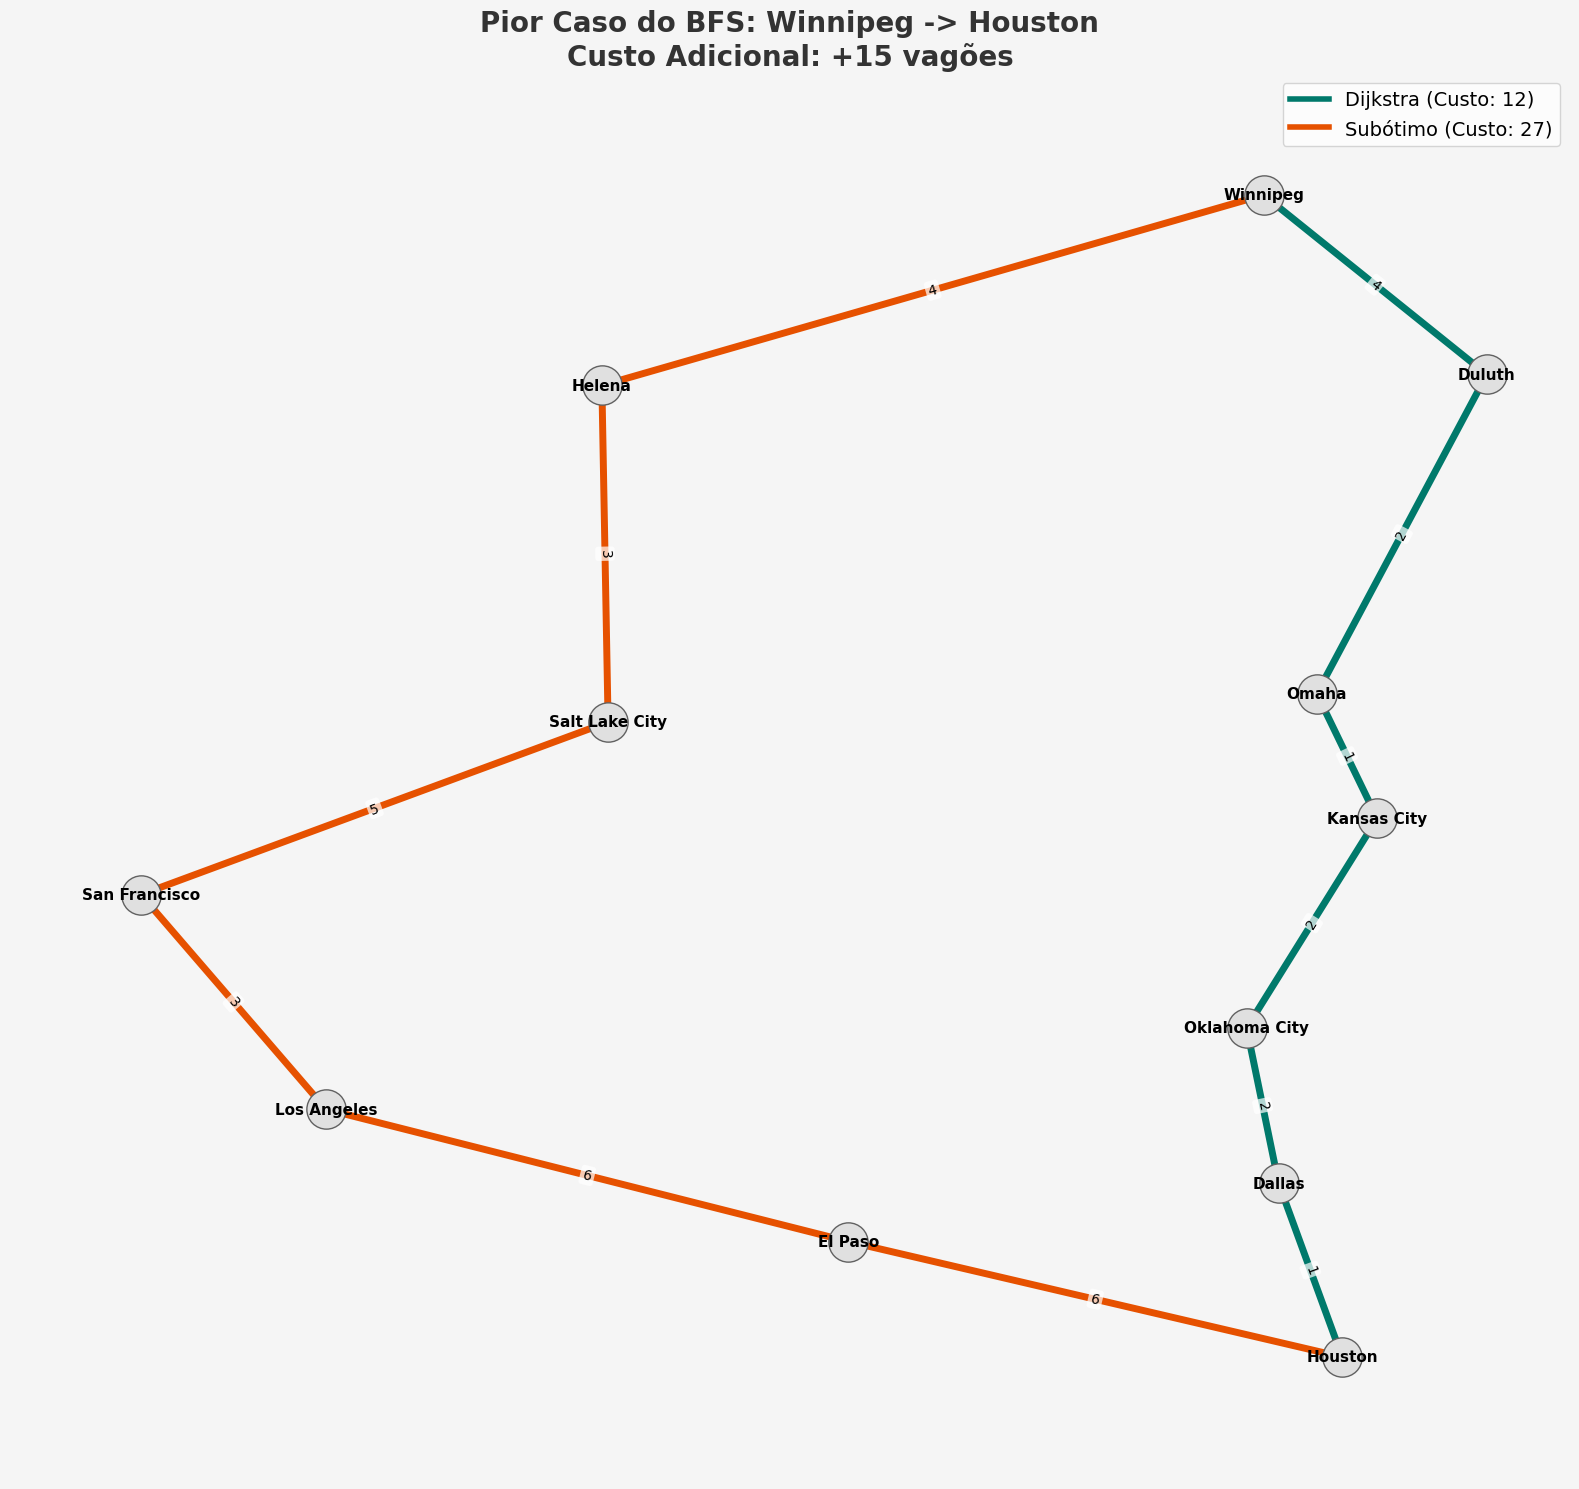

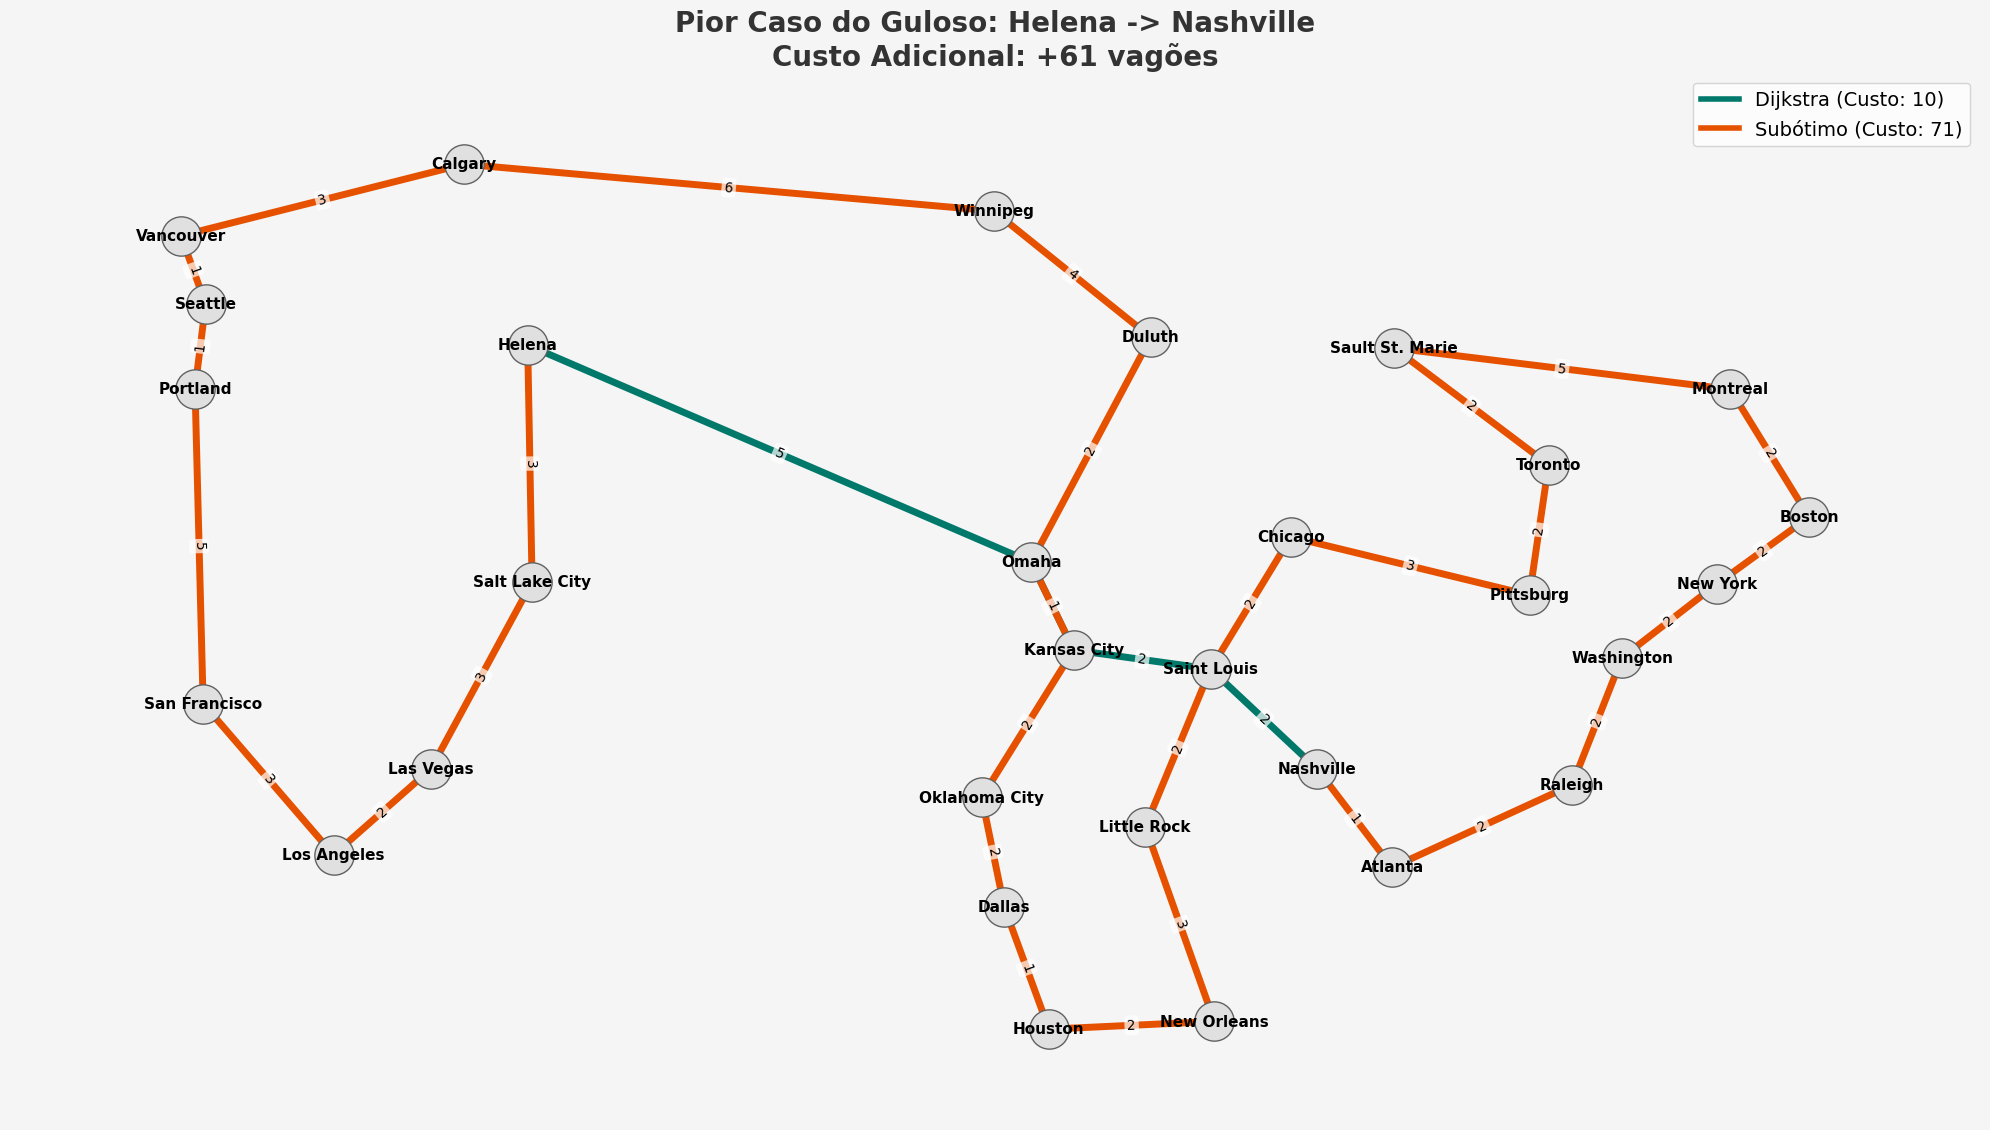

In [ ]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import itertools
import numpy as np

# --- 1. CONFIGURAÇÃO E CARREGAMENTO DOS DADOS ---

# Dicionários de coordenadas
coordenadas_america = {
    'Vancouver': (-123.12, 49.28), 'Calgary': (-114.07, 51.04), 'Winnipeg': (-97.13, 49.89), 'Seattle': (-122.33, 47.60),
    'Portland': (-122.67, 45.52), 'Helena': (-112.03, 46.59), 'Sault St. Marie': (-84.33, 46.52), 'Montreal': (-73.57, 45.50),
    'Toronto': (-79.38, 43.65), 'Duluth': (-92.10, 46.78), 'Omaha': (-95.93, 41.25), 'Denver': (-104.99, 39.73),
    'Salt Lake City': (-111.89, 40.76), 'San Francisco': (-122.41, 37.77), 'Los Angeles': (-118.24, 34.05),
    'Las Vegas': (-115.13, 36.16), 'Phoenix': (-112.07, 33.44), 'Santa Fe': (-105.93, 35.68), 'El Paso': (-106.48, 31.76),
    'Kansas City': (-94.57, 39.09), 'Oklahoma City': (-97.51, 35.46), 'Dallas': (-96.79, 32.77), 'Houston': (-95.36, 29.76),
    'Chicago': (-87.62, 41.87), 'Saint Louis': (-90.19, 38.62), 'Little Rock': (-92.28, 34.74), 'New Orleans': (-90.07, 29.95),
    'Pittsburg': (-79.99, 40.44), 'Nashville': (-86.78, 36.16), 'Atlanta': (-84.38, 33.74), 'Boston': (-71.05, 42.36),
    'New York': (-74.00, 40.71), 'Washington': (-77.03, 38.90), 'Raleigh': (-78.63, 35.77), 'Charleston': (-79.93, 32.77),
    'Miami': (-80.19, 25.76)
}
# CORRIGIDO: Dicionário completo com cidades e países para a Alemanha
coordenadas_alemanha = {
    'Kiel': (10.12, 54.32), 'Rostock': (12.14, 54.09), 'Schwerin': (11.40, 53.63), 'Hamburg': (9.99, 53.55),
    'Bremen': (8.80, 53.07), 'Bremerhaven': (8.60, 53.54), 'Emden': (7.20, 53.36), 'Hanover': (9.73, 52.37),
    'Berlin': (13.40, 52.52), 'Magdeburg': (11.62, 52.12), 'Munster': (7.62, 51.96), 'Dortmund': (7.46, 51.51),
    'Essen': (7.01, 51.45), 'Dusseldorf': (6.77, 51.22), 'Koln': (6.96, 50.93), 'Kassel': (9.47, 51.31),
    'Leipzig': (12.37, 51.33), 'Dresden': (13.73, 51.05), 'Erfurt': (11.02, 50.98), 'Chemnitz': (12.92, 50.83),
    'Koblenz': (7.60, 50.36), 'Frankfurt': (8.68, 50.11), 'Mainz': (8.24, 49.99), 'Wurzburg': (9.95, 49.79),
    'Nurnberg': (11.07, 49.45), 'Regensburg': (12.10, 49.02), 'Mannheim': (8.46, 49.48), 'Karlsruhe': (8.40, 49.00),
    'Saarbrucken': (6.99, 49.24), 'Stuttgart': (9.18, 48.77), 'Ulm': (9.99, 48.39), 'Augsburg': (10.89, 48.37),
    'Munchen': (11.58, 48.13), 'Lindau': (9.68, 47.54), 'Freiburg': (7.85, 47.99), 'Konstanz': (9.17, 47.66),
    # Países vizinhos que faltavam
    'Dinamarca': (10.0, 55.0), 'França': (6.2, 49.0), 'Suiça': (9.0, 47.1),
    'Austria': (12.8, 47.8), 'Holanda': (5.9, 51.8)
}


# --- Guia de Estilo para os Gráficos ---
STYLE_GUIDE = {
    "dijkstra_color": "#00796b",  # Azul-petróleo
    "suboptimal_color": "#e65100", # Laranja-queimado
    "node_color": "#e0e0e0",       # Cinza claro
    "node_border_color": "#616161",  # Cinza escuro
    "background_color": "#f5f5f5" # Cinza muito claro de fundo
}


def carregar_grafo_simples(mapa):
    if mapa == 'america': arquivo_csv = 'ticket_to_ride_north_america.csv'
    elif mapa == 'alemanha': arquivo_csv = 'ticket_to_ride_germany.csv'
    else: return None
    try: df = pd.read_csv(arquivo_csv)
    except FileNotFoundError: return None
    df.columns = [col.strip().title() for col in df.columns]
    df.dropna(subset=['Custo'], inplace=True)
    df['Custo'] = df['Custo'].astype(int)
    if mapa == 'america': df.replace("Saint Pauls", "Saint Louis", inplace=True)
    G = nx.Graph()
    for _, row in df.iterrows():
        u, v, custo = row["Origem"].strip(), row["Destino"].strip(), row["Custo"]
        if G.has_edge(u, v):
            if custo < G[u][v]['custo']: G[u][v]['custo'] = custo
        else:
            G.add_edge(u, v, custo=custo)
    return G

# --- 2. IMPLEMENTAÇÃO DOS ALGORITMOS E FUNÇÕES AUXILIARES ---

def path_to_edgelist(path):
    if not path or len(path) < 2: return []
    return list(zip(path[:-1], path[1:]))

def plot_worst_case_comparison(title, pos, dijkstra_path, suboptimal_path, G, aspect_ratio=1.0, filename="plot.pdf"):
    """Função de plotagem aprimorada com custos e melhor estética."""
    dijkstra_edges = path_to_edgelist(dijkstra_path)
    suboptimal_edges = path_to_edgelist(suboptimal_path)
    all_nodes = set(dijkstra_path) | set(suboptimal_path)

    plt.figure(figsize=(20, 15), facecolor=STYLE_GUIDE["background_color"])
    ax = plt.gca()
    ax.set_facecolor(STYLE_GUIDE["background_color"])
    plt.title(title, fontsize=20, fontweight='bold', color='#333333')

    nx.draw_networkx_nodes(G, pos, nodelist=all_nodes, node_size=800,
                           node_color=STYLE_GUIDE["node_color"],
                           edgecolors=STYLE_GUIDE["node_border_color"])
    nx.draw_networkx_labels(G, pos, labels={n: n for n in all_nodes}, font_size=11, font_weight='bold', font_family='sans-serif')

    nx.draw_networkx_edges(G, pos, edgelist=dijkstra_edges, width=5.0, edge_color=STYLE_GUIDE["dijkstra_color"])
    nx.draw_networkx_edges(G, pos, edgelist=suboptimal_edges, width=5.0, edge_color=STYLE_GUIDE["suboptimal_color"])

    edge_costs = nx.get_edge_attributes(G, 'custo')
    labels_to_draw = {edge: cost for edge, cost in edge_costs.items()
                      if edge in dijkstra_edges or tuple(reversed(edge)) in dijkstra_edges or
                         edge in suboptimal_edges or tuple(reversed(edge)) in suboptimal_edges}

    nx.draw_networkx_edge_labels(G, pos, edge_labels=labels_to_draw, font_size=10, font_color='black',
                                 bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', boxstyle='round,pad=0.2'))

    dijkstra_cost = nx.path_weight(G, dijkstra_path, 'custo')
    suboptimal_cost = nx.path_weight(G, suboptimal_path, 'custo')
    legend_handles = [
        plt.Line2D([0], [0], color=STYLE_GUIDE["dijkstra_color"], lw=4, label=f"Dijkstra (Custo: {dijkstra_cost})"),
        plt.Line2D([0], [0], color=STYLE_GUIDE["suboptimal_color"], lw=4, label=f"Subótimo (Custo: {suboptimal_cost})")
    ]
    plt.legend(handles=legend_handles, fontsize=14, loc='best')

    ax.set_aspect(aspect_ratio, adjustable='box')
    ax.axis("off")
    plt.tight_layout()
    plt.savefig(filename, format="pdf", bbox_inches="tight", facecolor=STYLE_GUIDE["background_color"])
    plt.show()

# (As funções de algoritmo permanecem as mesmas)
def algoritmo_guloso_dfs(graph, start_node, end_node):
    visited = {start_node}
    path = [start_node]
    total_cost = 0
    current_node = start_node
    while current_node != end_node:
        unvisited_neighbors = [n for n in graph.neighbors(current_node) if n not in visited]
        if not unvisited_neighbors: return None, np.inf
        best_next_node, min_cost = None, np.inf
        for neighbor in unvisited_neighbors:
            cost = graph[current_node][neighbor]['custo']
            if cost < min_cost:
                min_cost = cost
                best_next_node = neighbor
        if best_next_node is None: return None, np.inf
        total_cost += min_cost
        visited.add(best_next_node)
        path.append(best_next_node)
        current_node = best_next_node
    return path, total_cost

def algoritmo_dijkstra(graph, start_node, end_node):
    try:
        cost = nx.dijkstra_path_length(graph, start_node, end_node, weight='custo')
        path = nx.dijkstra_path(graph, start_node, end_node, weight='custo')
        return path, cost
    except nx.NetworkXNoPath:
        return None, np.inf

def algoritmo_bfs(graph, start_node, end_node):
    try:
        path = nx.shortest_path(graph, source=start_node, target=end_node)
        cost = nx.path_weight(graph, path, weight='custo')
        return path, cost
    except nx.NetworkXNoPath:
        return None, np.inf

# --- 3. EXECUÇÃO DA ANÁLISE COMPARATIVA ---

# --- ESCOLHA O MAPA AQUI ---
mapa_escolhido = 'america'

print(f"Carregando o mapa: {mapa_escolhido.title()}...")
G = carregar_grafo_simples(mapa_escolhido)
pos = coordenadas_america if mapa_escolhido == 'america' else coordenadas_alemanha
aspect_ratio = 1.3 if mapa_escolhido == 'america' else 1.0


if G:
    nodes = list(G.nodes())
    all_pairs = list(itertools.combinations(nodes, 2))
    results = []
    print(f"Analisando {len(all_pairs)} pares de cidades...")
    for i, (start, end) in enumerate(all_pairs):
        d_path, d_cost = algoritmo_dijkstra(G, start, end)
        b_path, b_cost = algoritmo_bfs(G, start, end)
        g_path, g_cost = algoritmo_guloso_dfs(G, start, end)
        results.append({
            'par': (start, end), 'dijkstra_path': d_path, 'dijkstra_cost': d_cost,
            'bfs_path': b_path, 'bfs_cost': b_cost, 'greedy_path': g_path,
            'greedy_cost': g_cost, 'greedy_failed': g_path is None
        })

    # --- 4. GERAÇÃO DE RELATÓRIO E GRÁFICOS ---
    df_results = pd.DataFrame(results)
    df_valid = df_results[~df_results['greedy_failed']].copy()

    if not df_valid.empty:
        df_valid['bfs_inefficiency'] = df_valid['bfs_cost'] - df_valid['dijkstra_cost']
        df_valid['greedy_inefficiency'] = df_valid['greedy_cost'] - df_valid['dijkstra_cost']

        # Pior caso do BFS
        worst_case_bfs = df_valid.loc[df_valid['bfs_inefficiency'].idxmax()]
        title_bfs = (f"Pior Caso do BFS: {worst_case_bfs['par'][0]} -> {worst_case_bfs['par'][1]}\n"
                     f"Custo Adicional: +{int(worst_case_bfs['bfs_inefficiency'])} vagões")
        plot_worst_case_comparison(title_bfs, pos, worst_case_bfs['dijkstra_path'],
                                   worst_case_bfs['bfs_path'], G, aspect_ratio,
                                   filename=f"pior_caso_bfs_{mapa_escolhido}.pdf")

        # Pior caso do Guloso
        worst_case_greedy = df_valid.loc[df_valid['greedy_inefficiency'].idxmax()]
        title_greedy = (f"Pior Caso do Guloso: {worst_case_greedy['par'][0]} -> {worst_case_greedy['par'][1]}\n"
                        f"Custo Adicional: +{int(worst_case_greedy['greedy_inefficiency'])} vagões")
        plot_worst_case_comparison(title_greedy, pos, worst_case_greedy['dijkstra_path'],
                                   worst_case_greedy['greedy_path'], G, aspect_ratio,
                                   filename=f"pior_caso_greedy_{mapa_escolhido}.pdf")
    else:
        print("Nenhuma comparação válida pôde ser feita para gerar gráficos.")